 # Import the Libraries

In [1]:
#import the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
import datetime
import inflection
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from matplotlib.pylab import rcParams
from sklearn.impute import KNNImputer
import statsmodels.api as sm
# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.vector_ar.vecm import coint_johansen 
import warnings
warnings.filterwarnings('ignore')
sns.set(rc={'figure.figsize':(15.7,6.27)})

# Load the dataset

In [2]:
df_sales_raw=pd.read_csv('train.csv')
df_store_raw=pd.read_csv('store.csv')
#Load the dataset

In [3]:
# Let's merge the dataset
df_raw = pd.merge(df_sales_raw, df_store_raw, how = 'left', on = 'Store' )
df_raw.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


# Data preparation & understanding

In [4]:
#Copy dataset
df_new = df_raw.copy()
df_new.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [5]:
#Let raname the columns
old_columns = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

new_columns = list( map( snakecase, old_columns ) )


#Rename Columns
df_new.columns = new_columns

In [6]:
df_new.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

In [7]:
#Let's check the shape of dataset
df_new.shape

(1017209, 18)

In [8]:
df_new[df_new['store']==9]

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
8,9,5,2015-07-31,8565,687,1,1,0,1,a,c,2030.0,8.0,2000.0,0,NaN,NaN,NaN
1123,9,4,2015-07-30,7539,651,1,1,0,1,a,c,2030.0,8.0,2000.0,0,NaN,NaN,NaN
2238,9,3,2015-07-29,7776,625,1,1,0,1,a,c,2030.0,8.0,2000.0,0,NaN,NaN,NaN
3353,9,2,2015-07-28,8751,678,1,1,0,1,a,c,2030.0,8.0,2000.0,0,NaN,NaN,NaN
4468,9,1,2015-07-27,10649,777,1,1,0,1,a,c,2030.0,8.0,2000.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1011643,9,6,2013-01-05,4254,450,1,0,0,0,a,c,2030.0,8.0,2000.0,0,NaN,NaN,NaN
1012758,9,5,2013-01-04,4798,497,1,0,0,1,a,c,2030.0,8.0,2000.0,0,NaN,NaN,NaN
1013873,9,4,2013-01-03,4602,453,1,0,0,1,a,c,2030.0,8.0,2000.0,0,NaN,NaN,NaN
1014988,9,3,2013-01-02,4903,481,1,0,0,1,a,c,2030.0,8.0,2000.0,0,NaN,NaN,NaN


In [9]:
#Store_9
df_new_store9=df_new[df_new['store']==9]

In [11]:
# transform datatype of the variable data to datetime
df_new_store9['date'] = pd.to_datetime( df_new_store9['date'])

In [13]:
df_new_store9.info()
#Let's check the info

<class 'pandas.core.frame.DataFrame'>
Int64Index: 942 entries, 8 to 1016103
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   store                         942 non-null    int64         
 1   day_of_week                   942 non-null    int64         
 2   date                          942 non-null    datetime64[ns]
 3   sales                         942 non-null    int64         
 4   customers                     942 non-null    int64         
 5   open                          942 non-null    int64         
 6   promo                         942 non-null    int64         
 7   state_holiday                 942 non-null    object        
 8   school_holiday                942 non-null    int64         
 9   store_type                    942 non-null    object        
 10  assortment                    942 non-null    object        
 11  competition_distance        

In [15]:
# Check NAN values
missing_count = df_new_store9.isnull().sum() # the count of missing values
value_count = df_new_store9.isnull().count() # the count of all values

missing_percentage = round(missing_count/value_count *100, 2) # the percentage of missing values
missing_df = pd.DataFrame({'missing values count': missing_count, 'percentage': missing_percentage})
missing_df

,missing values count,percentage
store,0,0.0
day_of_week,0,0.0
date,0,0.0
sales,0,0.0
customers,0,0.0
open,0,0.0
promo,0,0.0
state_holiday,0,0.0
school_holiday,0,0.0
store_type,0,0.0


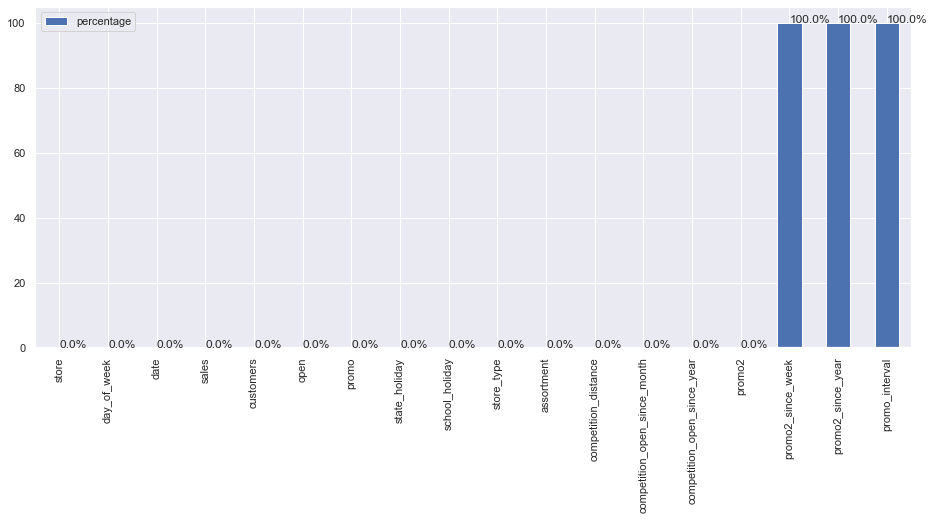

In [16]:
barchart = missing_df.plot.bar(y='percentage')
for index, percentage in enumerate( missing_percentage ):
    barchart.text( index, percentage, str(percentage)+'%')

In [27]:
#Let's drop the promo2_since_year,promo2_since_year,promo_interval
df_new_store9=df_new_store9.drop(['promo2_since_week', 'promo2_since_year','promo_interval'], axis = 1)

In [28]:
df_new_store9

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2
8,9,5,2015-07-31,8565,687,1,1,0,1,a,c,2030.0,8,2000,0
1123,9,4,2015-07-30,7539,651,1,1,0,1,a,c,2030.0,8,2000,0
2238,9,3,2015-07-29,7776,625,1,1,0,1,a,c,2030.0,8,2000,0
3353,9,2,2015-07-28,8751,678,1,1,0,1,a,c,2030.0,8,2000,0
4468,9,1,2015-07-27,10649,777,1,1,0,1,a,c,2030.0,8,2000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1011643,9,6,2013-01-05,4254,450,1,0,0,0,a,c,2030.0,8,2000,0
1012758,9,5,2013-01-04,4798,497,1,0,0,1,a,c,2030.0,8,2000,0
1013873,9,4,2013-01-03,4602,453,1,0,0,1,a,c,2030.0,8,2000,0
1014988,9,3,2013-01-02,4903,481,1,0,0,1,a,c,2030.0,8,2000,0


In [29]:
df_new_store9.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 942 entries, 8 to 1016103
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   store                         942 non-null    int64         
 1   day_of_week                   942 non-null    int64         
 2   date                          942 non-null    datetime64[ns]
 3   sales                         942 non-null    int64         
 4   customers                     942 non-null    int64         
 5   open                          942 non-null    int64         
 6   promo                         942 non-null    int64         
 7   state_holiday                 942 non-null    object        
 8   school_holiday                942 non-null    int64         
 9   store_type                    942 non-null    object        
 10  assortment                    942 non-null    object        
 11  competition_distance        

In [30]:
df_new_store9 = df_new_store9.astype({'competition_open_since_month':'int64', 'competition_open_since_year':'int64',})
df_new_store9.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 942 entries, 8 to 1016103
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   store                         942 non-null    int64         
 1   day_of_week                   942 non-null    int64         
 2   date                          942 non-null    datetime64[ns]
 3   sales                         942 non-null    int64         
 4   customers                     942 non-null    int64         
 5   open                          942 non-null    int64         
 6   promo                         942 non-null    int64         
 7   state_holiday                 942 non-null    object        
 8   school_holiday                942 non-null    int64         
 9   store_type                    942 non-null    object        
 10  assortment                    942 non-null    object        
 11  competition_distance        

In [31]:
# Let's copy the dataset
df_store9 = df_new_store9.copy()

In [32]:
df_store9.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2
8,9,5,2015-07-31,8565,687,1,1,0,1,a,c,2030.0,8,2000,0
1123,9,4,2015-07-30,7539,651,1,1,0,1,a,c,2030.0,8,2000,0
2238,9,3,2015-07-29,7776,625,1,1,0,1,a,c,2030.0,8,2000,0
3353,9,2,2015-07-28,8751,678,1,1,0,1,a,c,2030.0,8,2000,0
4468,9,1,2015-07-27,10649,777,1,1,0,1,a,c,2030.0,8,2000,0


**Descriptive Statistics**


In [33]:
df_store9.describe().T

,count,mean,std,min,25%,50%,75%,max
store,942.0,9.000000,0.000000,9.0,9.0,9.0,9.00,9.0
day_of_week,942.0,3.997877,1.998404,1.0,2.0,4.0,6.00,7.0
sales,942.0,5426.816348,2891.687966,0.0,4765.5,5904.5,7086.75,13457.0
customers,942.0,479.487261,238.656876,0.0,460.5,539.0,620.75,1019.0
open,942.0,0.826964,0.378479,0.0,1.0,1.0,1.00,1.0
promo,942.0,0.382166,0.486175,0.0,0.0,0.0,1.00,1.0
school_holiday,942.0,0.180467,0.384780,0.0,0.0,0.0,0.00,1.0
competition_distance,942.0,2030.000000,0.000000,2030.0,2030.0,2030.0,2030.00,2030.0
competition_open_since_month,942.0,8.000000,0.000000,8.0,8.0,8.0,8.00,8.0
competition_open_since_year,942.0,2000.000000,0.000000,2000.0,2000.0,2000.0,2000.00,2000.0


In [34]:
# separate numerical and categorical attributes
num_attributes = df_store9.select_dtypes( include = 'number')
cate_attributes = df_store9.select_dtypes( include = 'object')

**Numerical Attributes**

In [35]:
# Central Tendency - Mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion - std, min, max, range, skew, kurtoisis
d1 = pd.DataFrame(num_attributes.apply( np.std )).T
d2 = pd.DataFrame(num_attributes.apply( min )).T
d3 = pd.DataFrame(num_attributes.apply( max )).T
d4 = pd.DataFrame(num_attributes.apply( lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame(num_attributes.apply( lambda x: x.skew() )).T
d6 = pd.DataFrame(num_attributes.apply( lambda x: x.kurtosis() )).T

#concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()


m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,9.0,9.0,0.0,9.000000,9.0,0.000000,0.000000,0.000000
1,day_of_week,1.0,7.0,6.0,3.997877,4.0,1.997343,0.002127,-1.247185
2,sales,0.0,13457.0,13457.0,5426.816348,5904.5,2890.152692,-0.633586,0.008107
3,customers,0.0,1019.0,1019.0,479.487261,539.0,238.530167,-1.093070,0.234164
4,open,0.0,1.0,1.0,0.826964,1.0,0.378278,-1.731453,1.000047
5,promo,0.0,1.0,1.0,0.382166,0.0,0.485917,0.485772,-1.767783
6,school_holiday,0.0,1.0,1.0,0.180467,0.0,0.384576,1.664393,0.771837
7,competition_distance,2030.0,2030.0,0.0,2030.000000,2030.0,0.000000,0.000000,0.000000
8,competition_open_since_month,8.0,8.0,0.0,8.000000,8.0,0.000000,0.000000,0.000000
9,competition_open_since_year,2000.0,2000.0,0.0,2000.000000,2000.0,0.000000,0.000000,0.000000


**Categorical Attributes**

In [36]:
# check unique values of categorical features
cate_attributes.apply( lambda x: x.unique().shape[0])

state_holiday    5
store_type       1
assortment       1
dtype: int64

In [38]:
#Let's check the unique values
print(df_store9['state_holiday'].unique())
print(df_store9['store_type'].unique())
print(df_store9['assortment'].unique())

['0' 'a' 'b' 'c' 0]
['a']
['c']


# Exploratory data analysis(EDA)

Let’s perform EDA to gain insights into the given data.

**Univariate Analysis**

Response Variable (target)

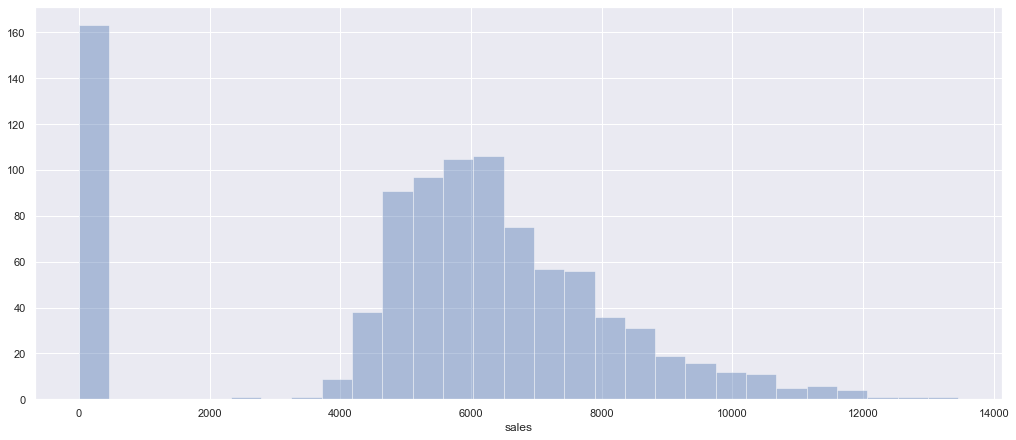

In [39]:
fig = plt.figure( figsize = (14, 6), constrained_layout=True)
sns.distplot(df_store9['sales'], kde = False);
plt.show()

**Numerical Variable**


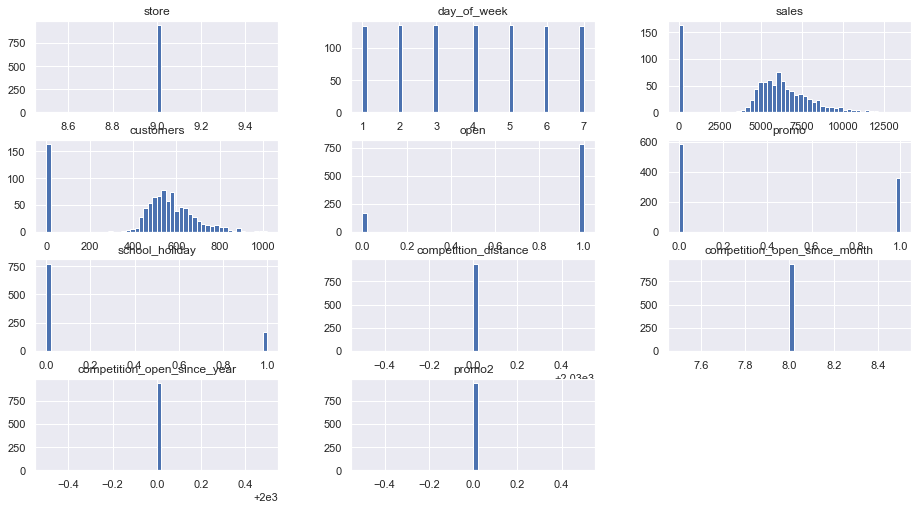

In [40]:
sns.set(rc={'figure.figsize':(15.7,8.27)})
num_attributes.hist(bins = 50);

In [41]:
df_store9['day_of_week'].value_counts()
#day of the week

5    135
4    135
3    135
2    135
7    134
6    134
1    134
Name: day_of_week, dtype: int64

In [42]:
df_store9['open'].value_counts()
# value count of store is open or not

1    779
0    163
Name: open, dtype: int64

In [43]:
df_store9['promo'].value_counts()
# value count of promo

0    582
1    360
Name: promo, dtype: int64

In [44]:
df_store9['state_holiday'].value_counts()
# value count of state_holiday

0    784
0    129
a     19
b      6
c      4
Name: state_holiday, dtype: int64

In [45]:
df_store9['school_holiday'].value_counts()
# value count of state_holiday

0    772
1    170
Name: school_holiday, dtype: int64

In [46]:
df_store9['store_type'].value_counts()
# value count of state_holiday

a    942
Name: store_type, dtype: int64

In [47]:
df_store9['assortment'].value_counts()
# value count of state_holiday

c    942
Name: assortment, dtype: int64

In [48]:
df_store9['competition_distance'].value_counts()
# value count of state_holiday

2030.0    942
Name: competition_distance, dtype: int64

In [49]:
df_store9['competition_open_since_month'].value_counts()
# value count of state_holiday

8    942
Name: competition_open_since_month, dtype: int64

In [50]:
df_store9['competition_open_since_year'].value_counts()
# value count of state_holiday

2000    942
Name: competition_open_since_year, dtype: int64

In [51]:
df_store9['promo2'].value_counts()
# value count of state_holiday

0    942
Name: promo2, dtype: int64

**Categorical Variable**

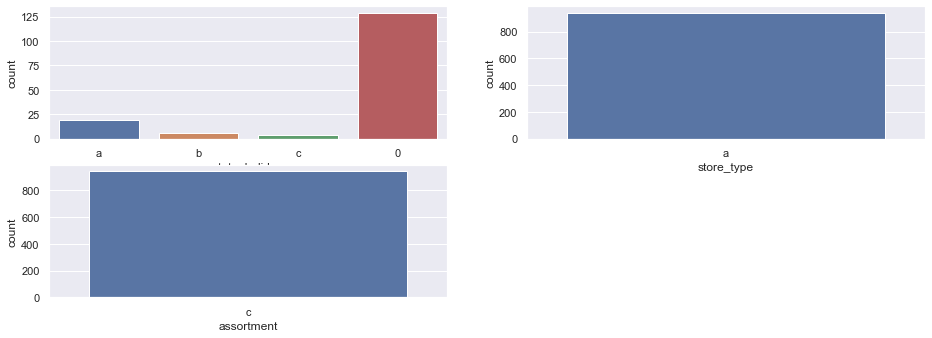

In [55]:
# state_holiday
plt.subplot(3, 2, 1)
a = df_store9[df_store9['state_holiday'] != '0']
sns.countplot(data = a, x = a['state_holiday'])

# store_type
plt.subplot(3, 2, 2)
sns.countplot(data = df_store9, x = df_store9['store_type'])

# assortment
plt.subplot(3, 2, 3)
sns.countplot(data = df_store9, x = df_store9['assortment'])

plt.show()

In [57]:
df_store9[df_store9['sales']==0]

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2
5583,9,7,2015-07-26,0,0,0,0,0,0,a,c,2030.0,8,2000,0
13388,9,7,2015-07-19,0,0,0,0,0,0,a,c,2030.0,8,2000,0
21193,9,7,2015-07-12,0,0,0,0,0,0,a,c,2030.0,8,2000,0
28998,9,7,2015-07-05,0,0,0,0,0,0,a,c,2030.0,8,2000,0
36803,9,7,2015-06-28,0,0,0,0,0,0,a,c,2030.0,8,2000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
987113,9,7,2013-01-27,0,0,0,0,0,0,a,c,2030.0,8,2000,0
994918,9,7,2013-01-20,0,0,0,0,0,0,a,c,2030.0,8,2000,0
1002723,9,7,2013-01-13,0,0,0,0,0,0,a,c,2030.0,8,2000,0
1010528,9,7,2013-01-06,0,0,0,0,0,0,a,c,2030.0,8,2000,0


In [58]:
df_store9.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 942 entries, 8 to 1016103
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   store                         942 non-null    int64         
 1   day_of_week                   942 non-null    int64         
 2   date                          942 non-null    datetime64[ns]
 3   sales                         942 non-null    int64         
 4   customers                     942 non-null    int64         
 5   open                          942 non-null    int64         
 6   promo                         942 non-null    int64         
 7   state_holiday                 942 non-null    object        
 8   school_holiday                942 non-null    int64         
 9   store_type                    942 non-null    object        
 10  assortment                    942 non-null    object        
 11  competition_distance        


-    Sale  and customer colomns has zero values which has to be imputed

-    Store is open on 80% of days

-    80% are regular days

-    All the rows of column-store type belongs to 'a'

-    All the rows of column-assortment belongs to 'c'

-    All the rows of columns-competition_distance to 2030

-    All the competition is opened since month-8

-    All the competition is opened since 2000

-    All the rows of promo2 belogs to 0

**Bivariate Analysis**

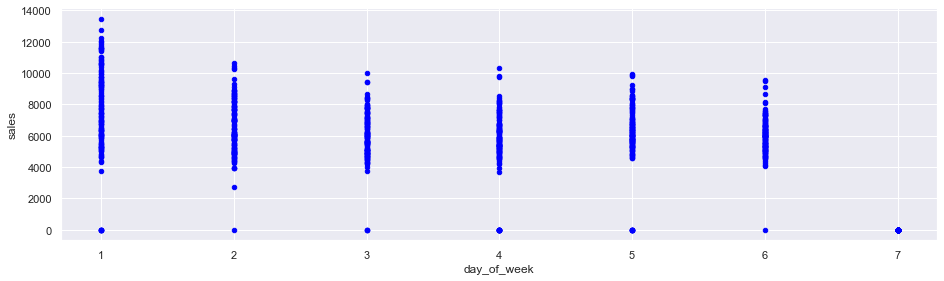

In [59]:
# lets draw a scatter plot between  Sales and day_of_week
sns.set(rc={'figure.figsize':(15.7,4.27)})
df_store9[['sales', 'day_of_week']].plot.scatter(x = 'day_of_week',y='sales',c='blue')
plt.show()

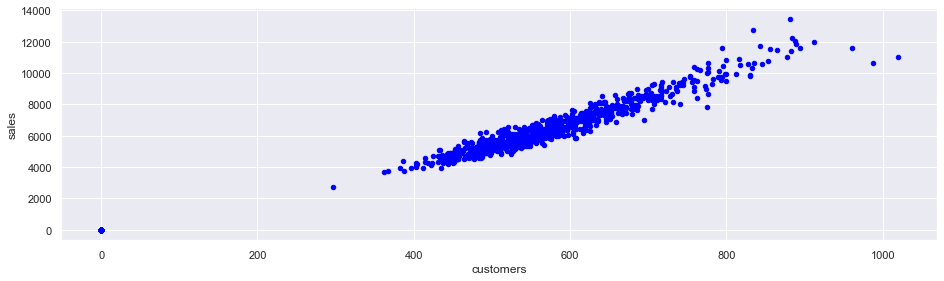

In [60]:
#Let's draw a scatter plot between Sales and Customers
df_store9[['sales', 'customers']].plot.scatter(x = 'customers',y='sales',c='blue')
plt.show()

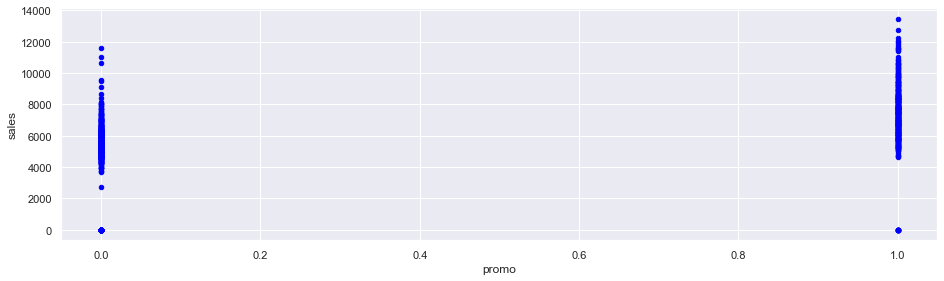

In [61]:
#Let's now draw a scatter plot between Sales and promo
df_store9[['sales', 'promo']].plot.scatter(x = 'promo',y='sales',c='blue')
plt.show()

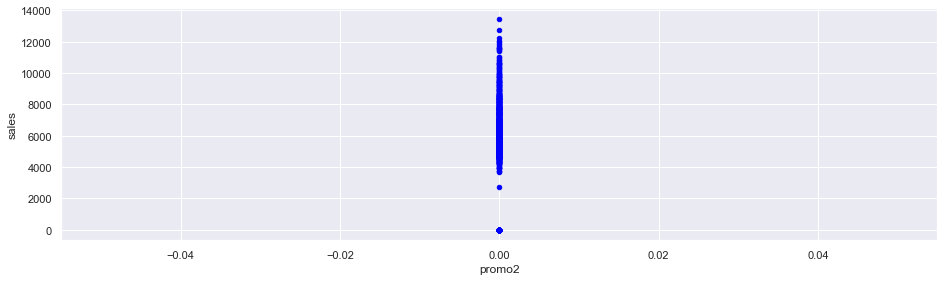

In [62]:
#Let's now draw a scatter plot between Sales and promo
df_store9[['sales', 'promo2']].plot.scatter(x = 'promo2',y='sales',c='blue')
plt.show()

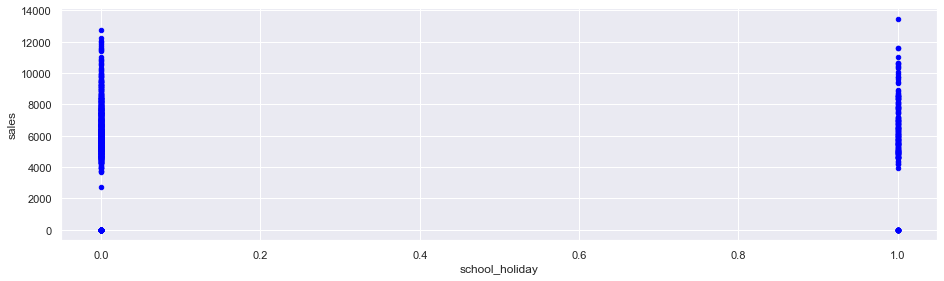

In [63]:
#lets now draw a scatter plot between  Sales and school_holiday
df_store9[['sales', 'school_holiday']].plot.scatter(x = 'school_holiday',y='sales',c='blue')
plt.show()

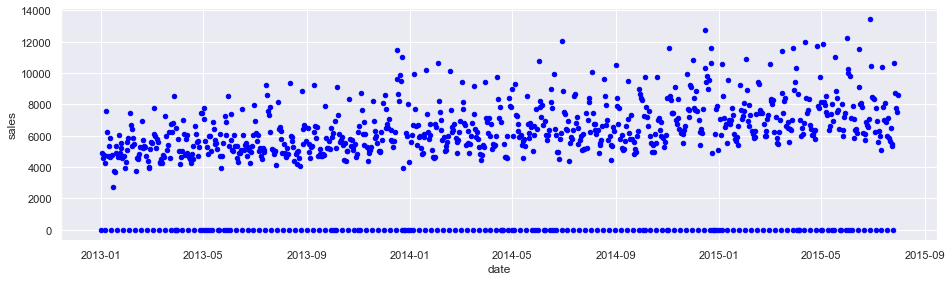

In [64]:
#lets now draw a scatter plot between Sales and date
df_store9[['sales', 'date']].plot.scatter(x = 'date',y='sales',c='blue')
plt.show()

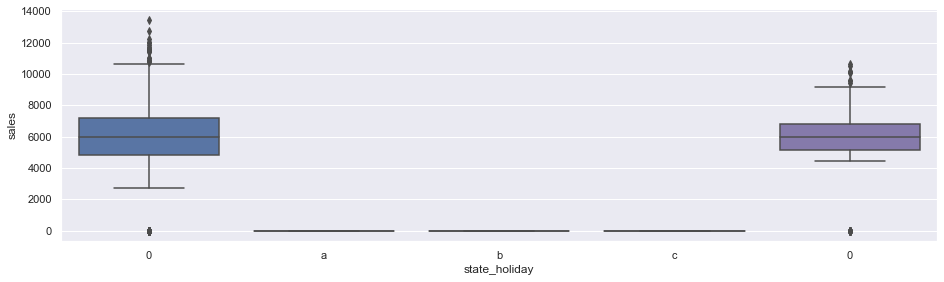

In [65]:
#Let's draw the boxplot between sales and state_holiday
sns.set(rc={'figure.figsize':(15.7,4.27)})
# create grouped boxplot 
sns.boxplot(x = df_store9['state_holiday'],
            y = df_store9['sales'])
plt.show()

**Multivariate Analysis**


**Numerical Attributes**

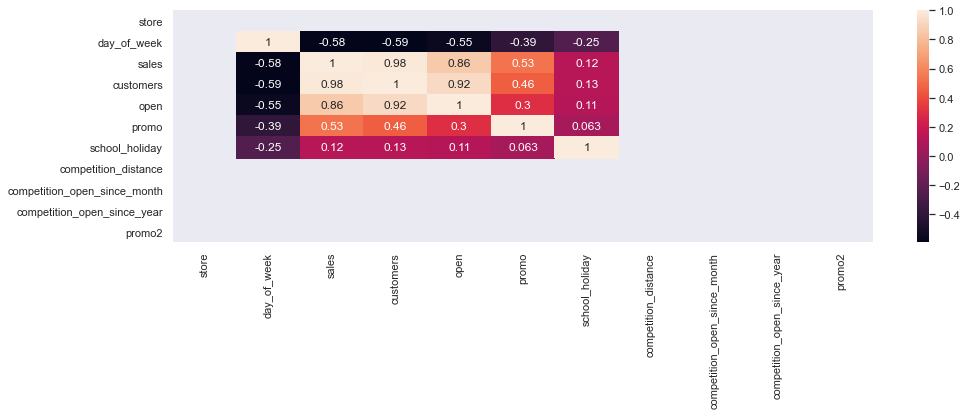

In [66]:
correlation = (num_attributes.corr( method = 'pearson' ))
sns.heatmap( correlation, annot = True );

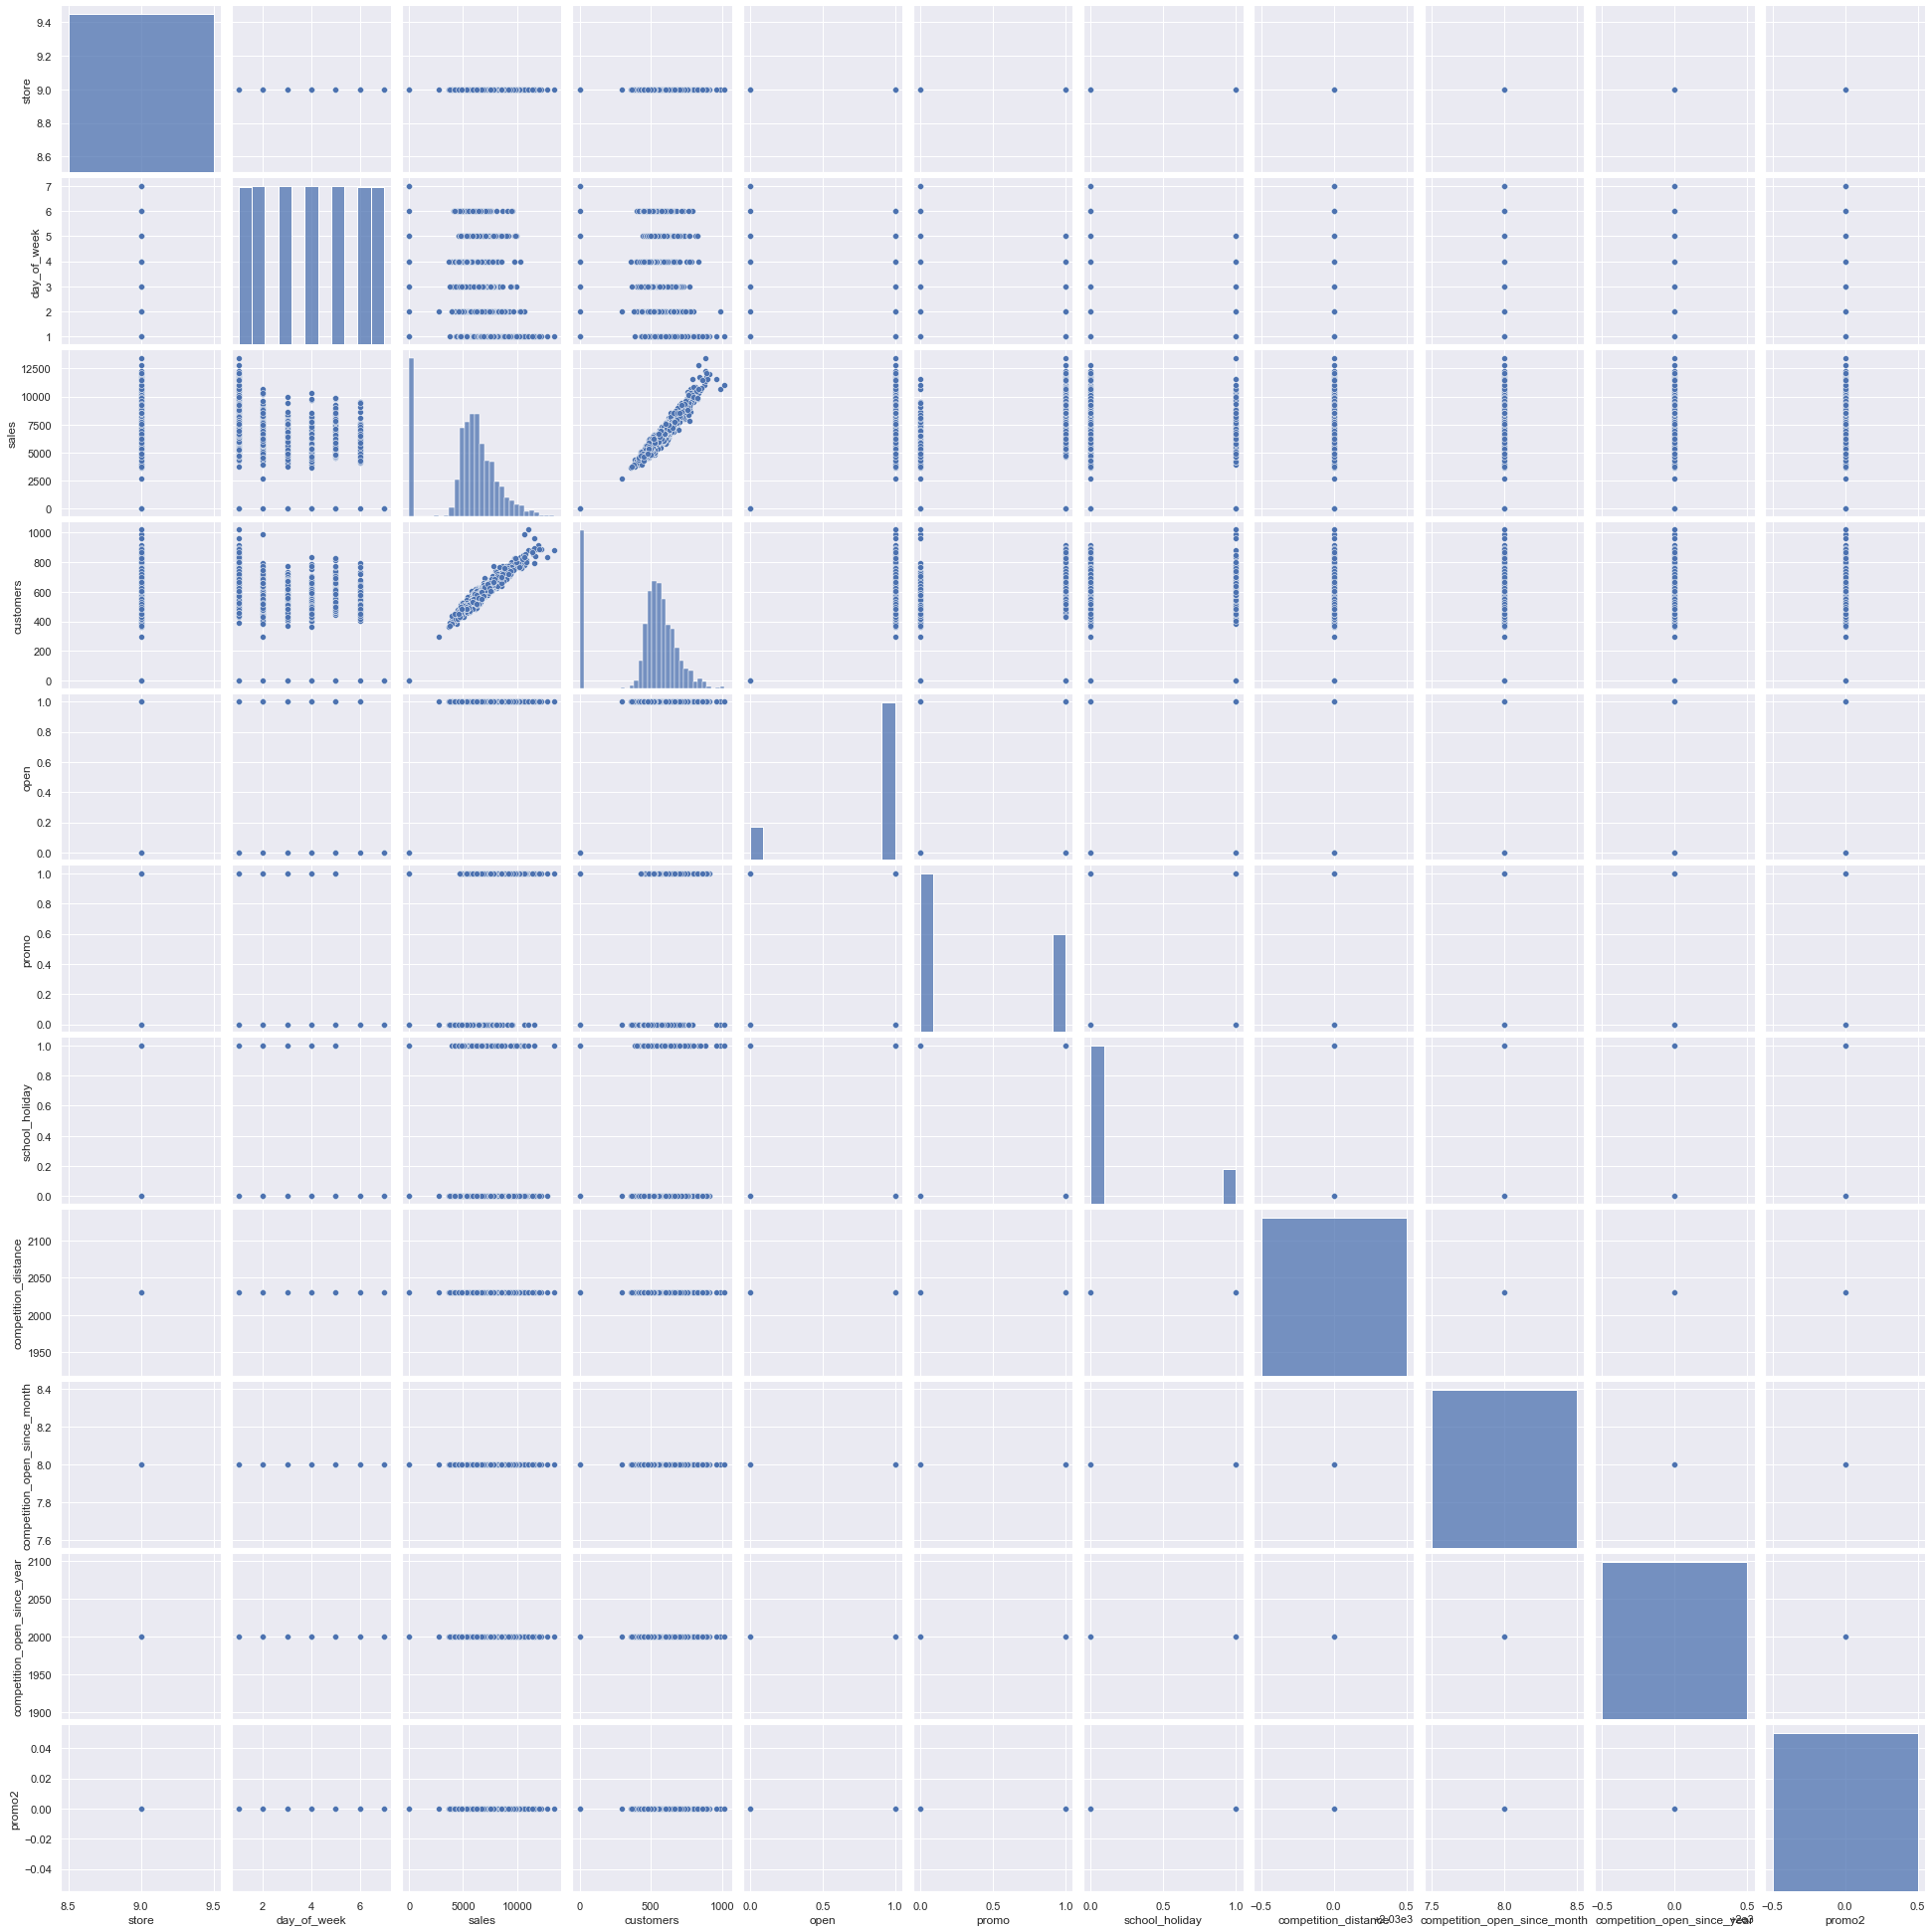

In [68]:
#pairplot with hue sales
sns.pairplot(df_store9)
# to show
plt.show()

**Some insights from EDA**

   - store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year

   - Day1,Day2 and Day4 have higher sales than other days

   - promo is correlated to sales

   - Promo2 doesn't have any effect on sales becuase it's value is equal to 0

   - There is no sale on a = public holiday, b = Easter holiday, c = Christmas

   - There is some effect of school holiday on sales

In [69]:
df_store9.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2'],
      dtype='object')

In [70]:
# We can drop store_type,assortment,competition_distance,competition_open_since_month,promo2_since_week,promo2_since_year,promo_interval
#competition_open_since_year & promo2
df_store9_new=df_store9.drop(['store_type', 'assortment','competition_distance','competition_open_since_month','competition_open_since_year'], axis = 1)

In [71]:
df_store9_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 942 entries, 8 to 1016103
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   store           942 non-null    int64         
 1   day_of_week     942 non-null    int64         
 2   date            942 non-null    datetime64[ns]
 3   sales           942 non-null    int64         
 4   customers       942 non-null    int64         
 5   open            942 non-null    int64         
 6   promo           942 non-null    int64         
 7   state_holiday   942 non-null    object        
 8   school_holiday  942 non-null    int64         
 9   promo2          942 non-null    int64         
dtypes: datetime64[ns](1), int64(8), object(1)
memory usage: 121.0+ KB


In [72]:
df_store9_new.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,promo2
8,9,5,2015-07-31,8565,687,1,1,0,1,0
1123,9,4,2015-07-30,7539,651,1,1,0,1,0
2238,9,3,2015-07-29,7776,625,1,1,0,1,0
3353,9,2,2015-07-28,8751,678,1,1,0,1,0
4468,9,1,2015-07-27,10649,777,1,1,0,1,0


In [73]:
# saving the dataframe
df_store9_new.to_csv('cleaned_df_store9.csv')

# Model Building

**ARIMA model**

In [74]:
path = "cleaned_df_store9.csv"
df_store9_new = pd.read_csv(path)
df_store9_new.head()
#Let load the data

,Unnamed: 0,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,promo2
0,8,9,5,2015-07-31,8565,687,1,1,0,1,0
1,1123,9,4,2015-07-30,7539,651,1,1,0,1,0
2,2238,9,3,2015-07-29,7776,625,1,1,0,1,0
3,3353,9,2,2015-07-28,8751,678,1,1,0,1,0
4,4468,9,1,2015-07-27,10649,777,1,1,0,1,0


In [75]:
df_store9_new=df_store9_new[::-1].reset_index()
df_store9_new.head()

,index,Unnamed: 0,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,promo2
0,941,1016103,9,2,2013-01-01,0,0,0,0,a,1,0
1,940,1014988,9,3,2013-01-02,4903,481,1,0,0,1,0
2,939,1013873,9,4,2013-01-03,4602,453,1,0,0,1,0
3,938,1012758,9,5,2013-01-04,4798,497,1,0,0,1,0
4,937,1011643,9,6,2013-01-05,4254,450,1,0,0,0,0


In [76]:
df_store9_new=df_store9_new.drop(['Unnamed: 0'], axis = 1)
df_store9_new=df_store9_new.drop(['index'], axis = 1)
df_store9_new.head()
#Let drop the Unnamed: 0 column

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,promo2
0,9,2,2013-01-01,0,0,0,0,a,1,0
1,9,3,2013-01-02,4903,481,1,0,0,1,0
2,9,4,2013-01-03,4602,453,1,0,0,1,0
3,9,5,2013-01-04,4798,497,1,0,0,1,0
4,9,6,2013-01-05,4254,450,1,0,0,0,0


In [77]:
df_store9_new.info()
#No missing value

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 942 entries, 0 to 941
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   store           942 non-null    int64 
 1   day_of_week     942 non-null    int64 
 2   date            942 non-null    object
 3   sales           942 non-null    int64 
 4   customers       942 non-null    int64 
 5   open            942 non-null    int64 
 6   promo           942 non-null    int64 
 7   state_holiday   942 non-null    object
 8   school_holiday  942 non-null    int64 
 9   promo2          942 non-null    int64 
dtypes: int64(8), object(2)
memory usage: 73.7+ KB


In [78]:
# transform datatype of the variable data to datetime
df_store9_new['date'] = pd.to_datetime(df_store9_new['date'])

In [79]:
indexed_df_store9_new = df_store9_new.set_index(['date'])
indexed_df_store9_new.head()
#Let set the date as index column

,store,day_of_week,sales,customers,open,promo,state_holiday,school_holiday,promo2
date,,,,,,,,,
2013-01-01,9,2,0,0,0,0,a,1,0
2013-01-02,9,3,4903,481,1,0,0,1,0
2013-01-03,9,4,4602,453,1,0,0,1,0
2013-01-04,9,5,4798,497,1,0,0,1,0
2013-01-05,9,6,4254,450,1,0,0,0,0


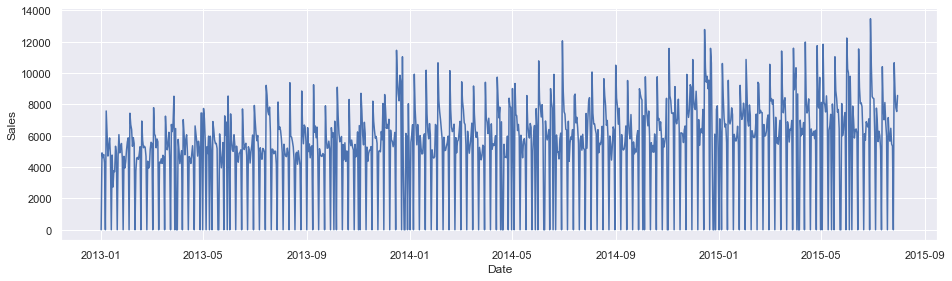

In [80]:
## plot graph
plt.xlabel('Date')
plt.ylabel('Sales')
plt.plot(indexed_df_store9_new['sales'])
plt.show()

In [81]:
#Let impute the zero values
(indexed_df_store9_new['sales']==0).sum()
# There are 163 zero value in sale column

163

In [82]:
indexed_df_store9_new['sales']=indexed_df_store9_new['sales'].replace(0, np.nan)

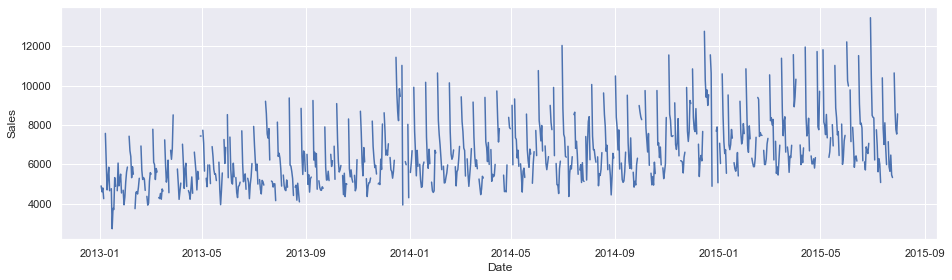

In [83]:
##plot graph
plt.xlabel('Date')
plt.ylabel('Sales')
plt.plot(indexed_df_store9_new['sales'])
plt.show()

In [84]:
#KNN imputer for filling NAN values
imputer = KNNImputer(n_neighbors=2)

In [85]:
indexed_df_store9_new['sales'] = imputer.fit_transform(np.array(indexed_df_store9_new['sales']).reshape(-1, 1))
indexed_df_store9_new['sales'].head()

date
2013-01-01    6562.337612
2013-01-02    4903.000000
2013-01-03    4602.000000
2013-01-04    4798.000000
2013-01-05    4254.000000
Name: sales, dtype: float64

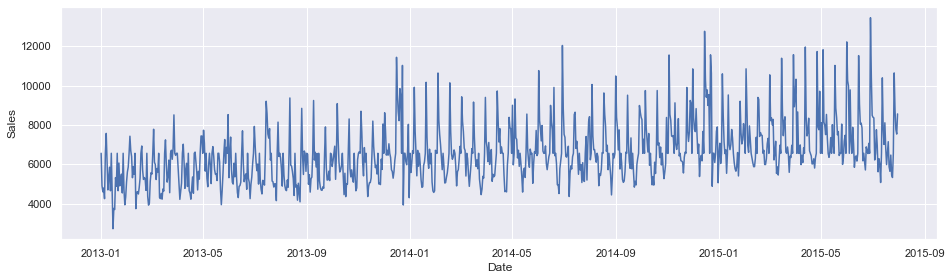

In [86]:
## plot graph
plt.xlabel('Date')
plt.ylabel('Sales')
plt.plot(indexed_df_store9_new['sales'])
plt.show()

In [87]:
(indexed_df_store9_new['sales']==0).sum()
# no missing value

0

**Outlier detection**

Box plot and interquartile range

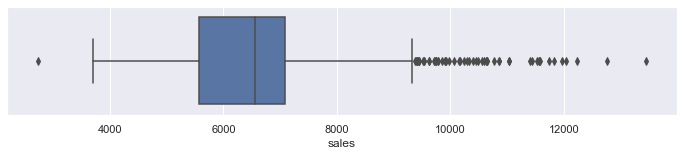

In [88]:
import seaborn as sns
fig = plt.subplots(figsize=(12, 2))
ax = sns.boxplot(x=indexed_df_store9_new['sales'],whis=1.5)
#Let treat the outliers

**Histogram**

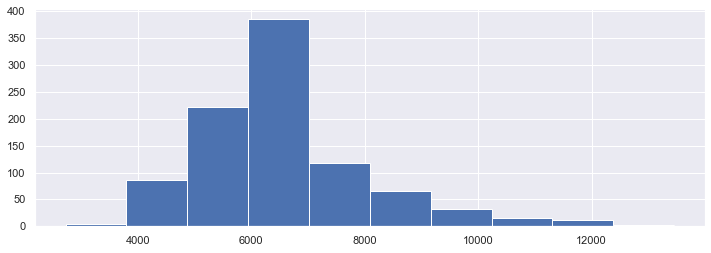

In [90]:
fig = indexed_df_store9_new['sales'].hist(figsize = (12,4))

In [92]:
percentile01 = indexed_df_store9_new['sales'].quantile(0.01)
percentile99 = indexed_df_store9_new['sales'].quantile(0.99)

In [93]:
upper_limit = percentile99
lower_limit = percentile01

In [94]:
upper_limit

11548.880000000001

In [95]:
lower_limit

4117.01

In [97]:
new_df = indexed_df_store9_new[indexed_df_store9_new['sales'] < upper_limit]
new_df.shape

(932, 9)

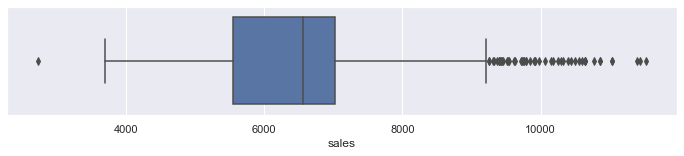

In [98]:
import seaborn as sns
fig = plt.subplots(figsize=(12, 2))
ax = sns.boxplot(x=new_df['sales'],whis=1.5)

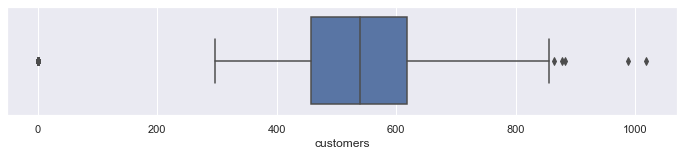

In [99]:
import seaborn as sns
fig = plt.subplots(figsize=(12, 2))
ax = sns.boxplot(x=new_df['customers'],whis=1.5)

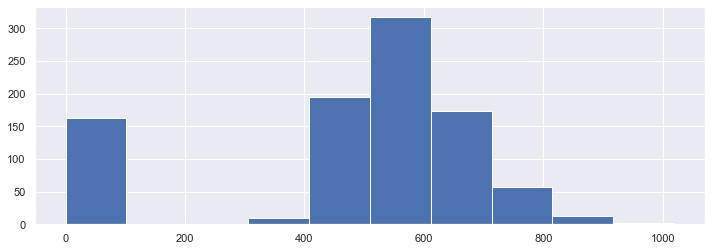

In [100]:
fig = new_df['customers'].hist(figsize = (12,4))

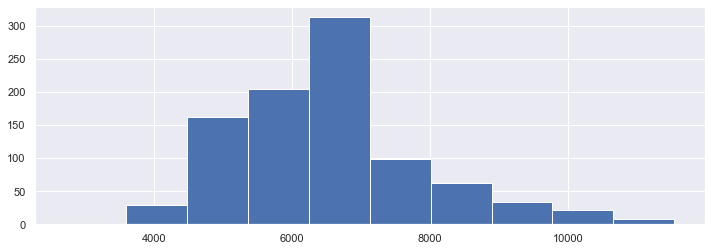

In [101]:
fig = new_df['sales'].hist(figsize = (12,4))

**ADF Stationary**

In [104]:
def test_stationarity(timeseries):
    
    #Determine rolling statistics
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()
    
    #Plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(indexed_df_store9_new['sales'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

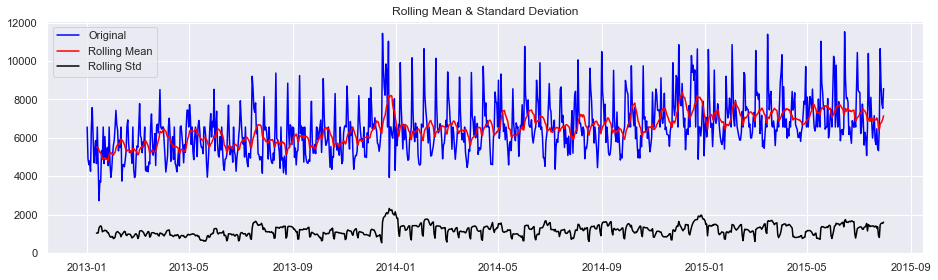

Results of Dickey Fuller Test:
Test Statistic                  -3.165813
p-value                          0.022051
#Lags Used                      22.000000
Number of Observations Used    919.000000
Critical Value (1%)             -3.437486
Critical Value (5%)             -2.864690
Critical Value (10%)            -2.568447
dtype: float64


In [105]:
test_stationarity(new_df['sales'])

- Null: Time Series is not stationary
- Alternate: Time Series is Stationary

**The p-value is less than 0.05 so The series is stationary**

In [106]:
from statsmodels.tsa.stattools import kpss
kpss_test = kpss(new_df['sales'])

print('KPSS Statistic: %f' % kpss_test[0])
print('Critical Values @ 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])

KPSS Statistic: 3.342234
Critical Values @ 0.05: 0.46
p-value: 0.010000


- Null: Time Series is not stationary
- Alternate: Time Series is Stationary
    
**The p-value is less than 0.05 so The series is non-stationary**

# Let's take the log of sales to Standardize the sales values

In [107]:
new_df.head()

,store,day_of_week,sales,customers,open,promo,state_holiday,school_holiday,promo2
date,,,,,,,,,
2013-01-01,9,2,6562.337612,0,0,0,a,1,0
2013-01-02,9,3,4903.000000,481,1,0,0,1,0
2013-01-03,9,4,4602.000000,453,1,0,0,1,0
2013-01-04,9,5,4798.000000,497,1,0,0,1,0
2013-01-05,9,6,4254.000000,450,1,0,0,0,0


In [108]:
#Log Transformation
new_df['sales_log'] = np.log(new_df['sales'])
new_df

,store,day_of_week,sales,customers,open,promo,state_holiday,school_holiday,promo2,sales_log
date,,,,,,,,,,
2013-01-01,9,2,6562.337612,0,0,0,a,1,0,8.789102
2013-01-02,9,3,4903.000000,481,1,0,0,1,0,8.497603
2013-01-03,9,4,4602.000000,453,1,0,0,1,0,8.434246
2013-01-04,9,5,4798.000000,497,1,0,0,1,0,8.475954
2013-01-05,9,6,4254.000000,450,1,0,0,0,0,8.355615
...,...,...,...,...,...,...,...,...,...,...
2015-07-27,9,1,10649.000000,777,1,1,0,1,0,9.273221
2015-07-28,9,2,8751.000000,678,1,1,0,1,0,9.076923
2015-07-29,9,3,7776.000000,625,1,1,0,1,0,8.958797


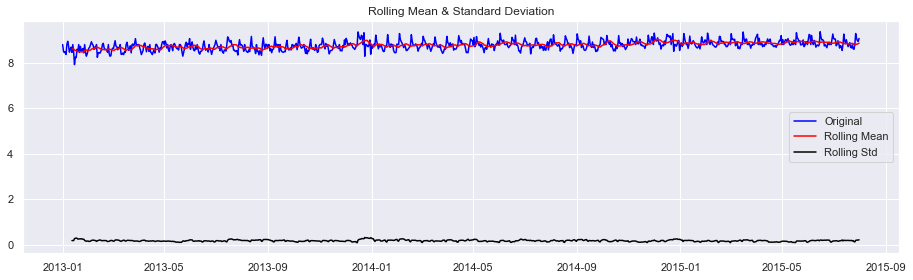

Results of Dickey Fuller Test:
Test Statistic                  -3.165813
p-value                          0.022051
#Lags Used                      22.000000
Number of Observations Used    919.000000
Critical Value (1%)             -3.437486
Critical Value (5%)             -2.864690
Critical Value (10%)            -2.568447
dtype: float64


In [109]:
test_stationarity(new_df['sales_log'])

**Log transformation has made mean & variance constant**

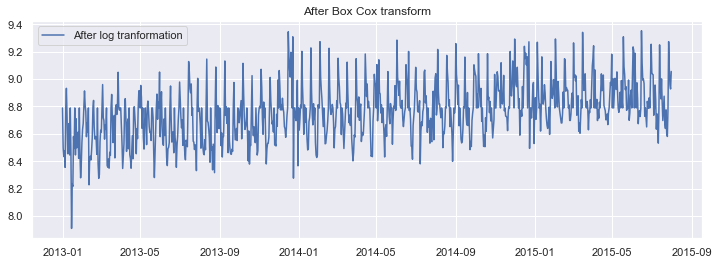

In [110]:
#After Log Transformation
plt.figure(figsize=(12,4))
plt.plot(new_df['sales_log'], label='After log tranformation')
plt.legend(loc='best')
plt.title('After Box Cox transform')
plt.show()

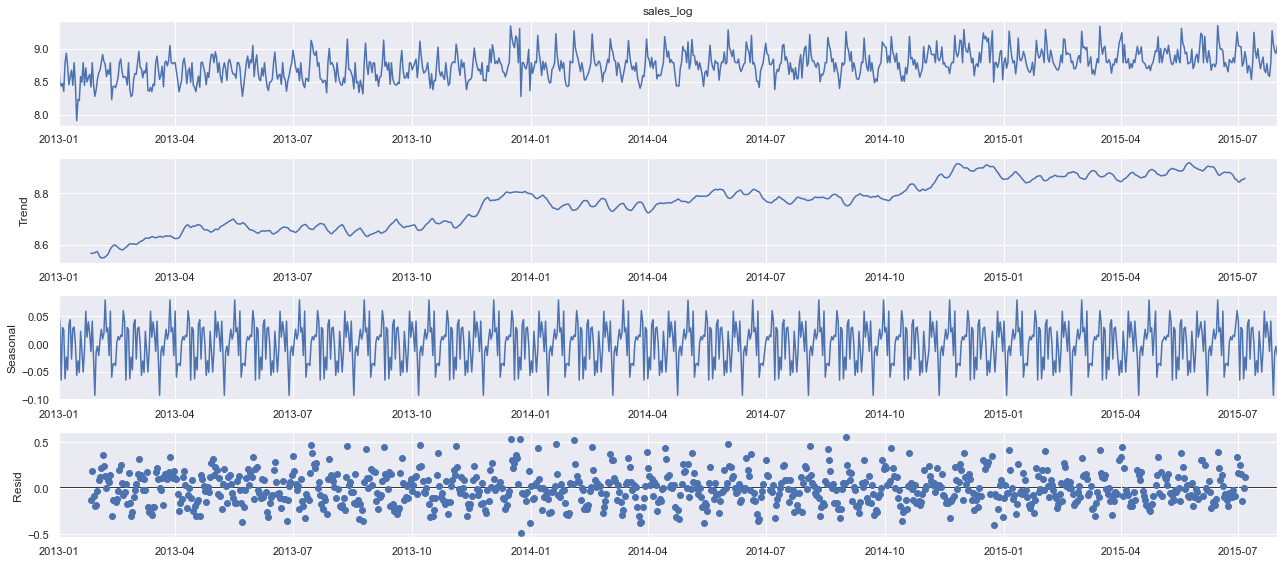

In [111]:
from matplotlib.pyplot import rcParams
rcParams['figure.figsize'] = 18,8
decomposition = sm.tsa.seasonal_decompose(new_df['sales_log'], model = "additive",period=50)
fig = decomposition.plot()

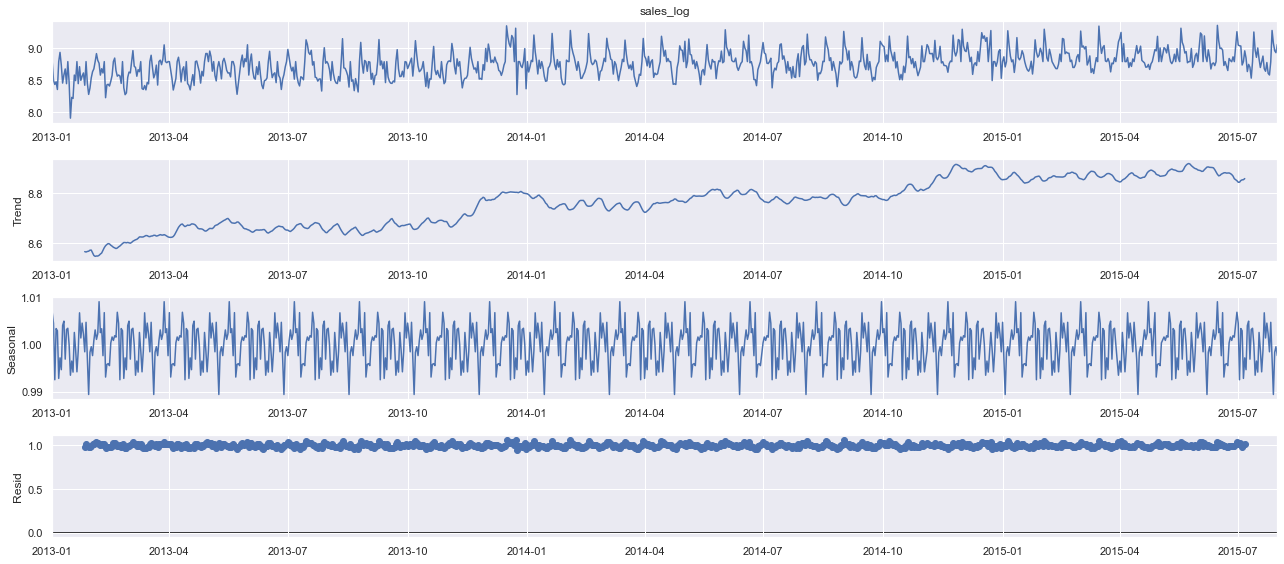

In [112]:
from matplotlib.pyplot import rcParams
rcParams['figure.figsize'] = 18,8
decomposition = sm.tsa.seasonal_decompose(new_df['sales_log'], model = "multiplicative",period=50)
fig = decomposition.plot()

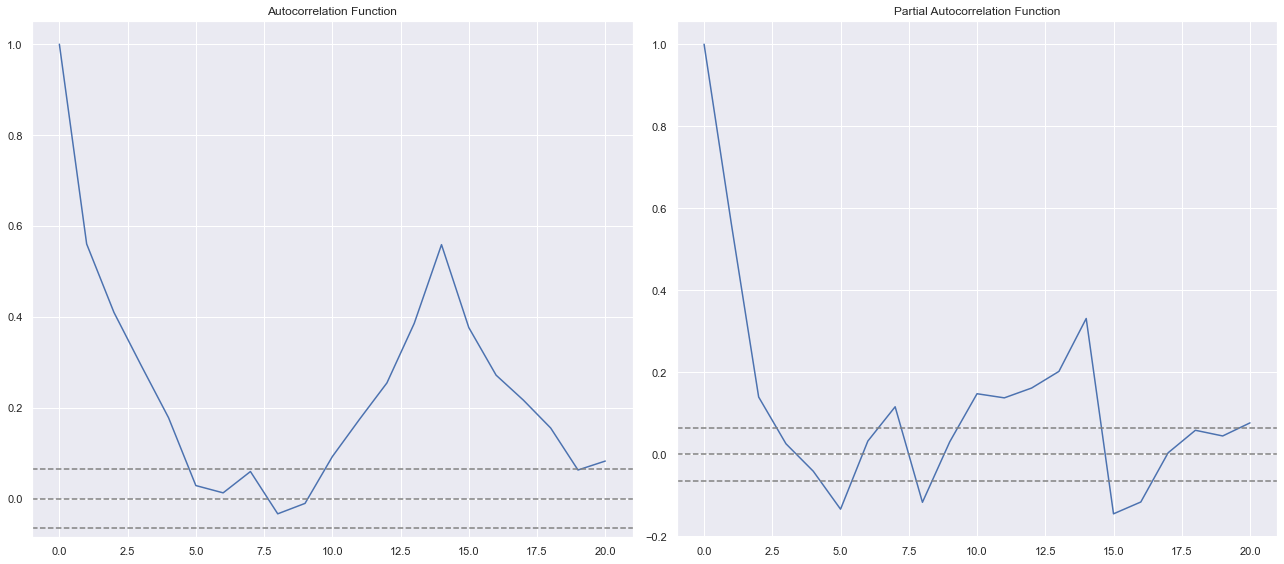

In [113]:
#ACF & PACF plots

lag_acf = acf(new_df['sales_log'], nlags=20) # MA 
lag_pacf = pacf(new_df['sales_log'], nlags=20, method='ols')  # AR 

#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(new_df['sales_log'])), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(new_df['sales_log'])), linestyle='--', color='gray')
plt.title('Autocorrelation Function')            

#Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(new_df['sales_log'])), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(new_df['sales_log'])), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
            
plt.tight_layout()

From the ACF graph, we see that curve touches y=0.0 line at x=5. Thus, from theory, Q = 5 From the PACF graph, we see that curve touches y=0.0 line at x=3. Thus, from theory, P = 3


**Build and evaluate time series forecast**

Split time series data into training and test set

In [114]:
train_len = 750
train = new_df['sales'][0:train_len] # first 750days as training set
test = new_df['sales'][train_len:] # last 182 days as out-of-time test set

In [115]:
print(train.shape)
print(test.shape)

(750,)
(182,)


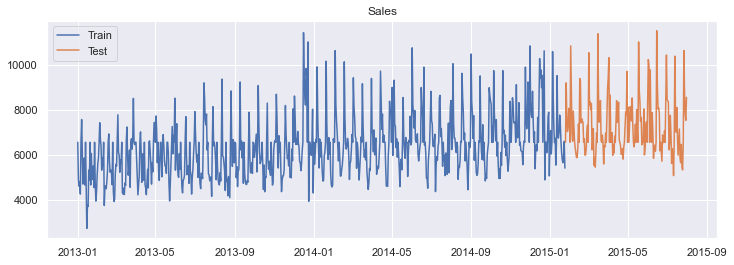

In [116]:
plt.figure(figsize=(12,4))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.legend(loc='best')
plt.title('Sales')
plt.show()

In [117]:
model = ARIMA(new_df['sales_log'], order=(2, 0, 2))
model_fit = model.fit()
print(model_fit.params)

const              8.759312
ar.L1.sales_log    1.363721
ar.L2.sales_log   -0.533534
ma.L1.sales_log   -0.902552
ma.L2.sales_log    0.297125
dtype: float64


In [118]:
new_df['ar_forecast_Log'] = model_fit.predict(new_df.index.min(), new_df.index.max())
new_df['arima_forecast'] = np.exp(new_df['ar_forecast_Log'])
new_df['arima_forecast']

date
2013-01-01    6369.730107
2013-01-02    6476.155308
2013-01-03    5668.328184
2013-01-04    5233.093191
2013-01-05    5233.208657
                 ...     
2015-07-27    6259.660228
2015-07-28    8141.227653
2015-07-29    8192.241171
2015-07-30    7558.457964
2015-07-31    7112.039949
Name: arima_forecast, Length: 932, dtype: float64

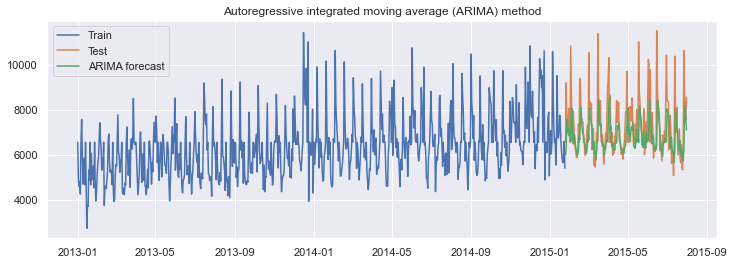

In [119]:
plt.figure(figsize=(12,4))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(new_df['arima_forecast'][test.index.min():], label='ARIMA forecast')
plt.legend(loc='best')
plt.title('Autoregressive integrated moving average (ARIMA) method')
plt.show()

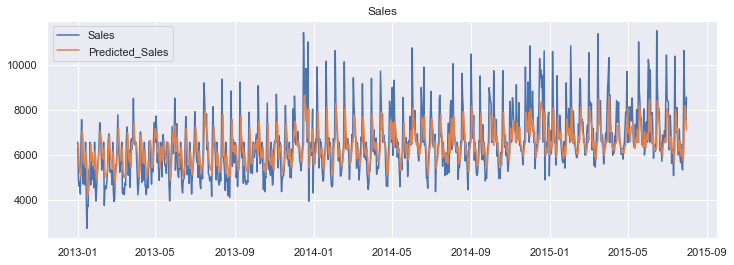

In [120]:
# plot the arima forecasting & Original series
plt.figure(figsize=(12,4))
plt.plot(new_df['sales'], label='Sales')
plt.plot(new_df['arima_forecast'], label='Predicted_Sales')
plt.legend(loc='best')
plt.title('Sales')
plt.show()

**Model Evalution**

In [121]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(test, new_df['arima_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test-new_df['arima_forecast'][test.index.min():])/test)*100,2)
Results = pd.DataFrame({'Method':['ARIMA'], 'RMSE': [rmse],'MAPE': [mape] })
Results

,Method,RMSE,MAPE
0,ARIMA,1290.57,10.53


**VAR model**

In [123]:
#Load the dataset
new_df.head()

,store,day_of_week,sales,customers,open,promo,state_holiday,school_holiday,promo2,sales_log,ar_forecast_Log,arima_forecast
date,,,,,,,,,,,,
2013-01-01,9,2,6562.337612,0,0,0,a,1,0,8.789102,8.759312,6369.730107
2013-01-02,9,3,4903.000000,481,1,0,0,1,0,8.497603,8.775882,6476.155308
2013-01-03,9,4,4602.000000,453,1,0,0,1,0,8.434246,8.642650,5668.328184
2013-01-04,9,5,4798.000000,497,1,0,0,1,0,8.475954,8.562758,5233.093191
2013-01-05,9,6,4254.000000,450,1,0,0,0,0,8.355615,8.562780,5233.208657


**Split the dataset to training & testing**

In [124]:
#split the dataset
nobs = 182
train, test = new_df[0:-nobs], new_df[-nobs:]

# Check size
print(train.shape)
print(test.shape)  

(750, 12)
(182, 12)


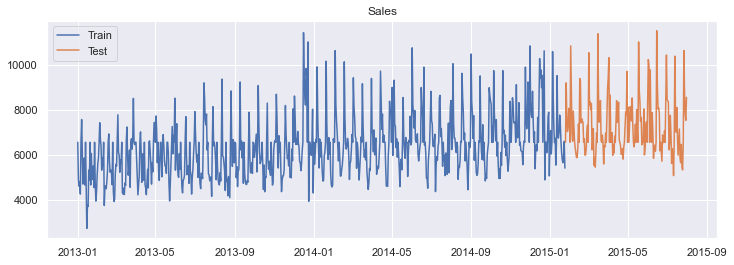

In [125]:
plt.figure(figsize=(12,4))
plt.plot(train['sales'], label='Train')
plt.plot(test['sales'], label='Test')
plt.legend(loc='best')
plt.title('Sales')
plt.show()

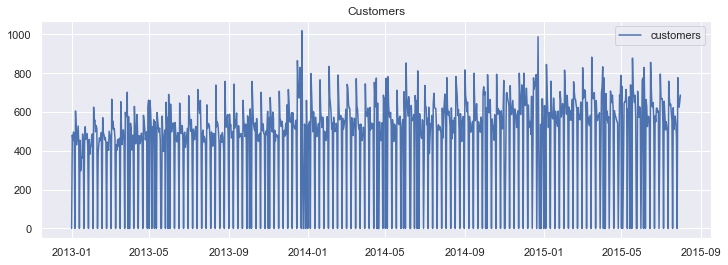

In [126]:
#plot the arima forecasting & Original series
plt.figure(figsize=(12,4))
plt.plot(new_df['customers'],label='customers')
plt.legend(loc='best')
plt.title('Customers')
plt.show()

In [127]:
(new_df['customers']==0).sum()

163

In [128]:
#impute the NAN values
new_df['customers']=new_df['customers'].replace(0, np.nan)

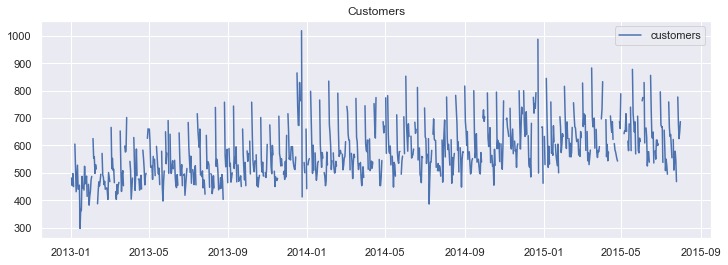

In [129]:
#plot the arima forecasting & Original series
plt.figure(figsize=(12,4))
plt.plot(new_df['customers'],label='customers')
plt.legend(loc='best')
plt.title('Customers')
plt.show()

In [130]:
#KNN imputer for filling NAN values
imputer = KNNImputer(n_neighbors=2)

In [131]:
new_df['customers'] = imputer.fit_transform(np.array(new_df['customers']).reshape(-1, 1))
new_df['customers'].head()

date
2013-01-01    575.936281
2013-01-02    481.000000
2013-01-03    453.000000
2013-01-04    497.000000
2013-01-05    450.000000
Name: customers, dtype: float64

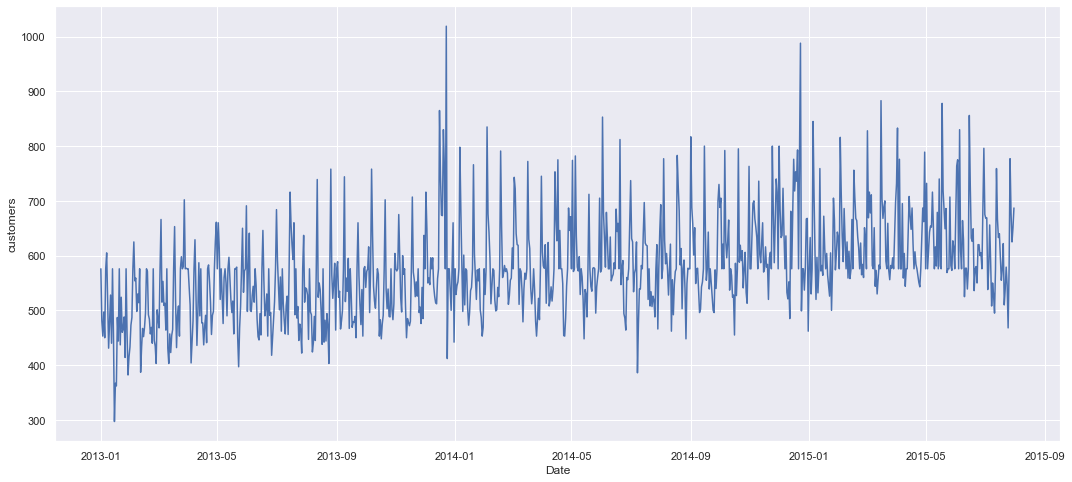

In [132]:
## plot graph
plt.xlabel('Date')
plt.ylabel('customers')
plt.plot(new_df['customers'])
plt.show()

In [133]:
new_df.head()

,store,day_of_week,sales,customers,open,promo,state_holiday,school_holiday,promo2,sales_log,ar_forecast_Log,arima_forecast
date,,,,,,,,,,,,
2013-01-01,9,2,6562.337612,575.936281,0,0,a,1,0,8.789102,8.759312,6369.730107
2013-01-02,9,3,4903.000000,481.000000,1,0,0,1,0,8.497603,8.775882,6476.155308
2013-01-03,9,4,4602.000000,453.000000,1,0,0,1,0,8.434246,8.642650,5668.328184
2013-01-04,9,5,4798.000000,497.000000,1,0,0,1,0,8.475954,8.562758,5233.093191
2013-01-05,9,6,4254.000000,450.000000,1,0,0,0,0,8.355615,8.562780,5233.208657


**ADF test**

In [134]:
def test_stationarity(timeseries):
    
    #Determine rolling statistics
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()
    
    #Plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(new_df['customers'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

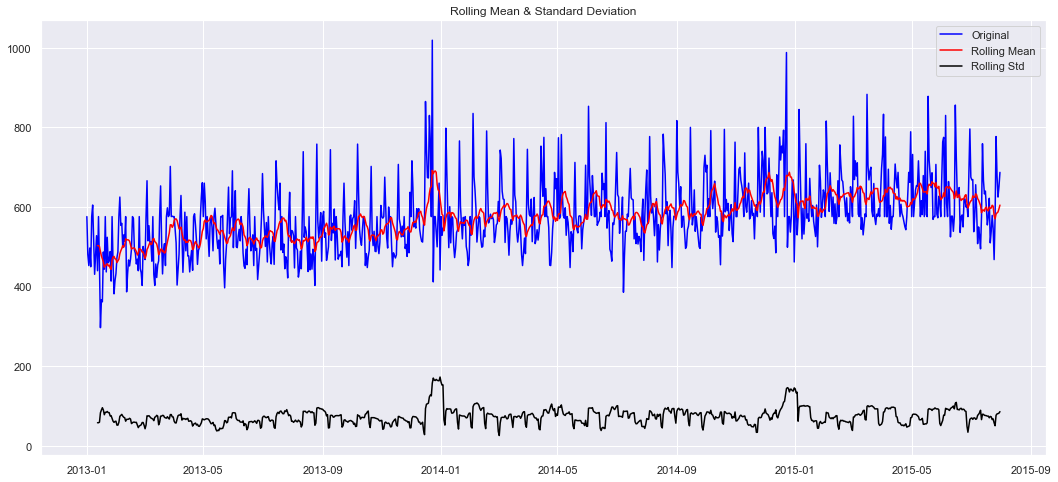

Results of Dickey Fuller Test:
Test Statistic                  -3.096754
p-value                          0.026794
#Lags Used                      20.000000
Number of Observations Used    911.000000
Critical Value (1%)             -3.437548
Critical Value (5%)             -2.864718
Critical Value (10%)            -2.568462
dtype: float64


In [135]:
test_stationarity(new_df['customers'])

- Null: Time Series is not stationary
- Alternate: Time Series is Stationary

**The p-value is less than 0.05 so The series is stationary**

In [136]:
from statsmodels.tsa.stattools import kpss
kpss_test = kpss(new_df['customers'])

print('KPSS Statistic: %f' % kpss_test[0])
print('Critical Values @ 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])

KPSS Statistic: 3.411945
Critical Values @ 0.05: 0.46
p-value: 0.010000


- Null: Time Series is not stationary
- Alternate: Time Series is Stationary

**The p-value is less than 0.05 so The series is non-stationary**

In [138]:
#Log Transformation
new_df['customers_log'] = np.log(new_df['customers'])
new_df

,store,day_of_week,sales,customers,open,promo,state_holiday,school_holiday,promo2,sales_log,ar_forecast_Log,arima_forecast,customers_log
date,,,,,,,,,,,,,
2013-01-01,9,2,6562.337612,575.936281,0,0,a,1,0,8.789102,8.759312,6369.730107,6.355997
2013-01-02,9,3,4903.000000,481.000000,1,0,0,1,0,8.497603,8.775882,6476.155308,6.175867
2013-01-03,9,4,4602.000000,453.000000,1,0,0,1,0,8.434246,8.642650,5668.328184,6.115892
2013-01-04,9,5,4798.000000,497.000000,1,0,0,1,0,8.475954,8.562758,5233.093191,6.208590
2013-01-05,9,6,4254.000000,450.000000,1,0,0,0,0,8.355615,8.562780,5233.208657,6.109248
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-07-27,9,1,10649.000000,777.000000,1,1,0,1,0,9.273221,8.741881,6259.660228,6.655440
2015-07-28,9,2,8751.000000,678.000000,1,1,0,1,0,9.076923,9.004696,8141.227653,6.519147
2015-07-29,9,3,7776.000000,625.000000,1,1,0,1,0,8.958797,9.010943,8192.241171,6.437752


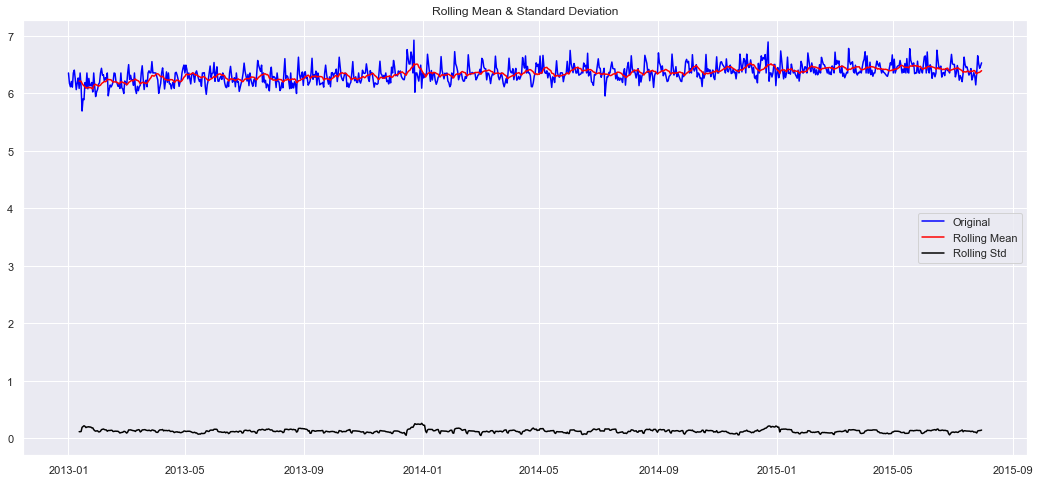

Results of Dickey Fuller Test:
Test Statistic                  -3.096754
p-value                          0.026794
#Lags Used                      20.000000
Number of Observations Used    911.000000
Critical Value (1%)             -3.437548
Critical Value (5%)             -2.864718
Critical Value (10%)            -2.568462
dtype: float64


In [139]:
test_stationarity(new_df['customers_log'])

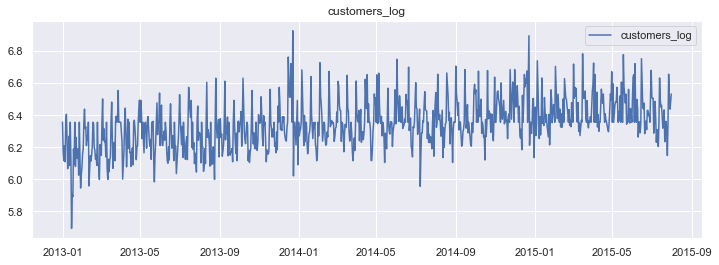

In [140]:
#plot the arima Log series
plt.figure(figsize=(12,4))
plt.plot(new_df['customers_log'],label='customers_log')
plt.legend(loc='best')
plt.title('customers_log')
plt.show()

In [141]:
#Let's check the info
new_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 932 entries, 2013-01-01 to 2015-07-31
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   store            932 non-null    int64  
 1   day_of_week      932 non-null    int64  
 2   sales            932 non-null    float64
 3   customers        932 non-null    float64
 4   open             932 non-null    int64  
 5   promo            932 non-null    int64  
 6   state_holiday    932 non-null    object 
 7   school_holiday   932 non-null    int64  
 8   promo2           932 non-null    int64  
 9   sales_log        932 non-null    float64
 10  ar_forecast_Log  932 non-null    float64
 11  arima_forecast   932 non-null    float64
 12  customers_log    932 non-null    float64
dtypes: float64(6), int64(6), object(1)
memory usage: 141.9+ KB


**Log transformation has made mean & variance constant**


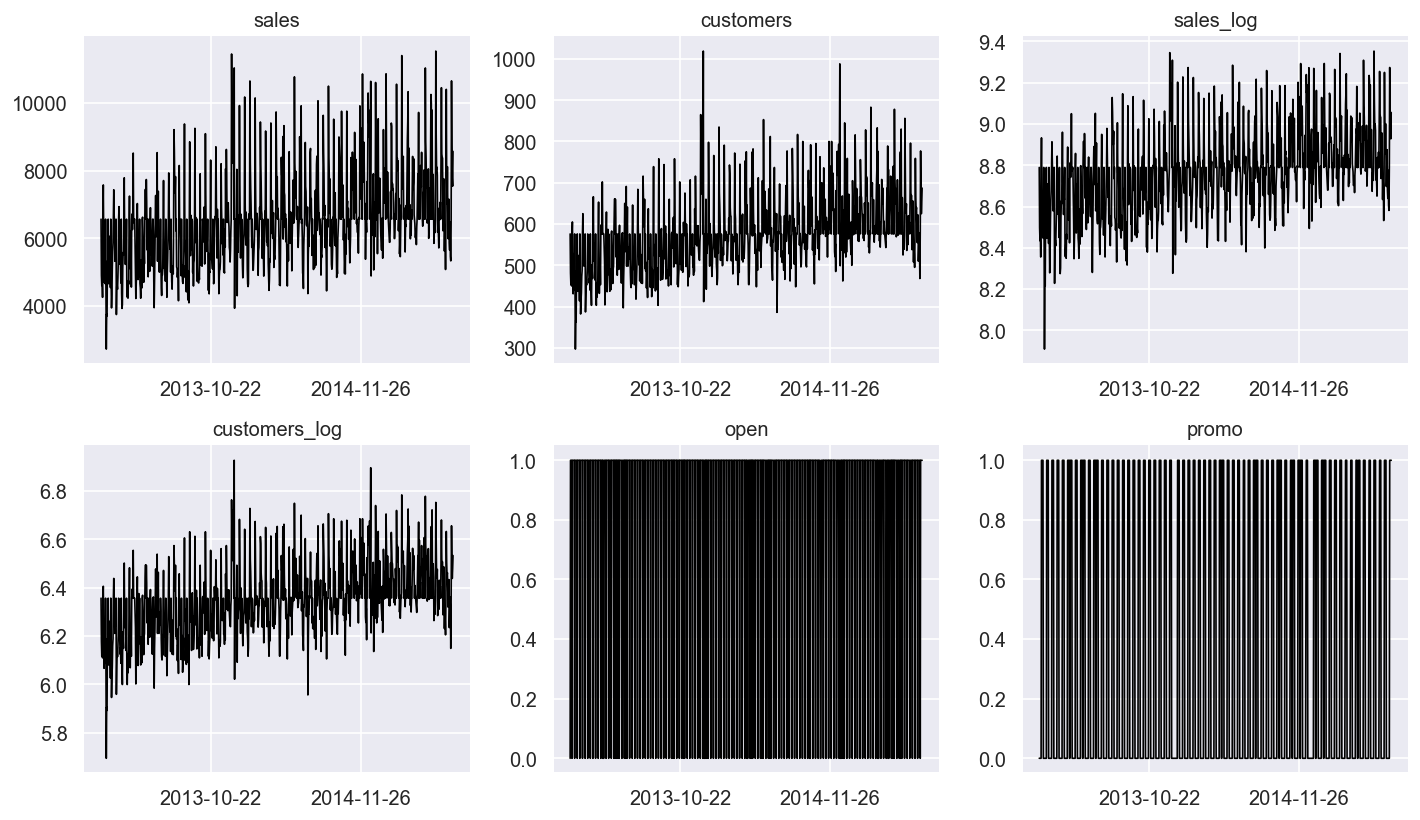

In [142]:
# Plot
ls=['sales','customers','sales_log','customers_log','open','promo','state_holiday','promo2','school_holiday']
df=new_df[ls]
fig, axes = plt.subplots(nrows=2, ncols=3, dpi=120, figsize=(12,7))
for i, ax in enumerate(axes.flatten()):
        ax.plot(df[df.columns[i]], color='black', linewidth=1)
        ax.xaxis.set_major_locator(plt.MaxNLocator(3))
        # Decorations
        ax.set_title(df.columns[i])
        ax.xaxis.set_ticks_position('none')
        ax.yaxis.set_ticks_position('none')
        ax.spines["top"].set_alpha(0)
        ax.tick_params(labelsize=12)

plt.tight_layout();

In [143]:
new_df.columns

Index(['store', 'day_of_week', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'promo2', 'sales_log',
       'ar_forecast_Log', 'arima_forecast', 'customers_log'],
      dtype='object')

In [144]:
new_df1=new_df[['sales_log', 'customers_log']]
new_df1

,sales_log,customers_log
date,,
2013-01-01,8.789102,6.355997
2013-01-02,8.497603,6.175867
2013-01-03,8.434246,6.115892
2013-01-04,8.475954,6.208590
2013-01-05,8.355615,6.109248
...,...,...
2015-07-27,9.273221,6.655440
2015-07-28,9.076923,6.519147
2015-07-29,8.958797,6.437752


In [145]:
#Let's create a model
model = VAR(new_df1)
for i in [1,2,3,4,5]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  -10.011271397251155
BIC :  -9.980103238643569
FPE :  4.4891084220242956e-05
HQIC:  -9.99938429917061 

Lag Order = 2
AIC :  -10.035489894594367
BIC :  -9.983498662485255
FPE :  4.381695621124856e-05
HQIC:  -10.01566014242595 

Lag Order = 3
AIC :  -10.070591212733245
BIC :  -9.997741350146168
FPE :  4.230561906553033e-05
HQIC:  -10.042804420676928 

Lag Order = 4
AIC :  -10.086791836197705
BIC :  -9.993047686208318
FPE :  4.1625790457229154e-05
HQIC:  -10.051033576979899 

Lag Order = 5
AIC :  -10.102652691079838
BIC :  -9.98797849642779
FPE :  4.097081954425901e-05
HQIC:  -10.058908495790114 



In [146]:
x = model.select_order(maxlags=5)
x.summary()

,AIC,BIC,FPE,HQIC
0,-9.562,-9.551,7.038e-05,-9.558
1,-10.01,-9.982,4.482e-05,-10.00
2,-10.04,-9.984,4.380e-05,-10.02
3,-10.07,-9.998*,4.227e-05,-10.04
4,-10.09,-9.993,4.162e-05,-10.05
5,-10.10*,-9.988,4.097e-05*,-10.06*


In [147]:
#Let's fit the model
model_fitted = model.fit()
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 14, Jan, 2022
Time:                     23:27:38
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -9.98010
Nobs:                     931.000    HQIC:                  -9.99938
Log likelihood:           2024.18    FPE:                4.48911e-05
AIC:                     -10.0113    Det(Omega_mle):     4.46032e-05
--------------------------------------------------------------------
Results for equation sales_log
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                    3.954382         0.234914           16.833           0.000
L1.sales_log             1.109970         0.097754           11.355           0.000
L1.customers_log        -0.775062         0.

In [148]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

1


In [149]:
# Input data for forecasting
forecast_input = new_df1.values[-lag_order:]
forecast_input

array([[9.05543941, 6.53233429]])

In [150]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=182)
df_forecast = pd.DataFrame(fc, index=new_df.index[-182:], columns=new_df1.columns + '_2d')
df_forecast

,sales_log_2d,customers_log_2d
date,,
2015-01-25,8.942684,6.468873
2015-01-26,8.866716,6.419021
2015-01-27,8.821032,6.387789
2015-01-28,8.794531,6.369424
2015-01-29,8.779349,6.358853
...,...,...
2015-07-27,8.759258,6.344832
2015-07-28,8.759258,6.344832
2015-07-29,8.759258,6.344832


In [151]:
df_forecast['VAR_forecast_Sales'] = np.exp(df_forecast['sales_log_2d'])
df_forecast['VAR_forecast_customers'] = np.exp(df_forecast['customers_log_2d'])
df_forecast

,sales_log_2d,customers_log_2d,VAR_forecast_Sales,VAR_forecast_customers
date,,,,
2015-01-25,8.942684,6.468873,7651.710504,644.756941
2015-01-26,8.866716,6.419021,7091.952992,613.402007
2015-01-27,8.821032,6.387789,6775.255809,594.540759
2015-01-28,8.794531,6.369424,6598.060944,583.721680
2015-01-29,8.779349,6.358853,6498.647919,577.583433
...,...,...,...,...
2015-07-27,8.759258,6.344832,6369.383954,569.541629
2015-07-28,8.759258,6.344832,6369.383954,569.541629
2015-07-29,8.759258,6.344832,6369.383954,569.541629


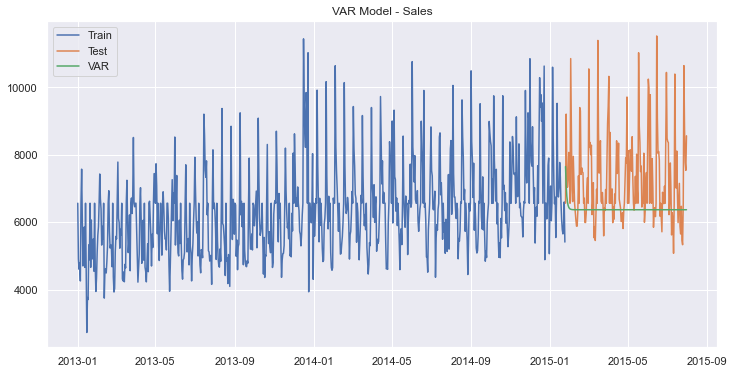

In [152]:
plt.figure(figsize=(12,6)) 
plt.plot(train['sales'], label='Train')
plt.plot(test['sales'], label='Test')
plt.plot(df_forecast['VAR_forecast_Sales'], label='VAR')
plt.legend(loc='best')
plt.title('VAR Model - Sales')
plt.show()

In [153]:
train_len = 750
train1 = new_df[0:train_len] # first 890days as training set
test1 = new_df[train_len:] # last 42 days as out-of-time test set

In [154]:
train1

,store,day_of_week,sales,customers,open,promo,state_holiday,school_holiday,promo2,sales_log,ar_forecast_Log,arima_forecast,customers_log
date,,,,,,,,,,,,,
2013-01-01,9,2,6562.337612,575.936281,0,0,a,1,0,8.789102,8.759312,6369.730107,6.355997
2013-01-02,9,3,4903.000000,481.000000,1,0,0,1,0,8.497603,8.775882,6476.155308,6.175867
2013-01-03,9,4,4602.000000,453.000000,1,0,0,1,0,8.434246,8.642650,5668.328184,6.115892
2013-01-04,9,5,4798.000000,497.000000,1,0,0,1,0,8.475954,8.562758,5233.093191,6.208590
2013-01-05,9,6,4254.000000,450.000000,1,0,0,0,0,8.355615,8.562780,5233.208657,6.109248
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-01-20,9,2,5778.000000,564.000000,1,0,0,0,0,8.661813,8.734525,6213.780744,6.335054
2015-01-21,9,3,5651.000000,545.000000,1,0,0,0,0,8.639588,8.692913,5960.518818,6.300786
2015-01-22,9,4,5905.000000,526.000000,1,0,0,0,0,8.683555,8.674585,5852.269809,6.265301


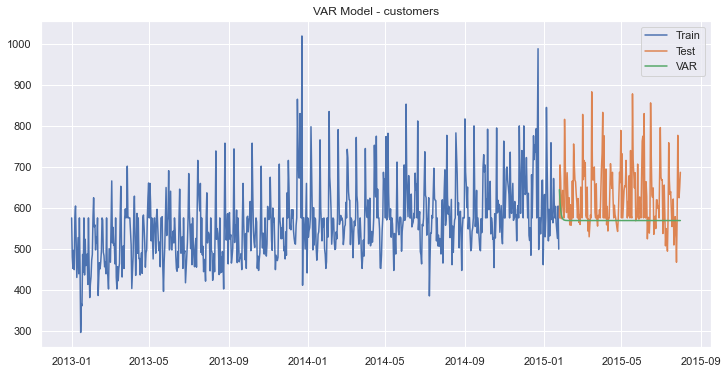

In [155]:
plt.figure(figsize=(12,6)) 
plt.plot(train1['customers'], label='Train')
plt.plot(test1['customers'], label='Test')
plt.plot(df_forecast['VAR_forecast_customers'], label='VAR')
plt.legend(loc='best')
plt.title('VAR Model - customers')
plt.show()

**Model Evalution**

In [157]:
# Let's calculate the rmse and MAPE
rmse = np.sqrt(mean_squared_error(test['sales'], df_forecast['VAR_forecast_Sales'])).round(2)
mape = np.round(np.mean(np.abs(test['sales']-df_forecast['VAR_forecast_Sales'])/test['sales'])*100,2)
tempResults = pd.DataFrame({'Method':['VAR'], 'RMSE': [rmse],'MAPE': [mape] })

In [158]:
tempResults

,Method,RMSE,MAPE
0,VAR,1566.32,13.08


In [159]:
results = pd.concat([Results , tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,ARIMA,1290.57,10.53
0,VAR,1566.32,13.08


**Johansen-Impulse**

In [160]:
joh_model1 = coint_johansen(new_df[['sales','customers']],-1,1)

In [161]:
joh_model1

In [162]:
joh_model1.lr2

array([179.07084463,   1.56447848])

In [163]:
joh_model1.lr1

array([180.63532311,   1.56447848])

In [164]:
new_df[['sales','customers']].shape

(932, 2)

In [165]:
def joh_output(res):
    output = pd.DataFrame([res.lr2,res.lr1],
                          index=['max_eig_stat',"trace_stat"])
    print(output.T,'\n')
    print("Critical values(90%, 95%, 99%) of max_eig_stat\n",res.cvm,'\n')
    print("Critical values(90%, 95%, 99%) of trace_stat\n",res.cvt,'\n')

In [166]:
joh_output(joh_model1)

   max_eig_stat  trace_stat
0    179.070845  180.635323
1      1.564478    1.564478 

Critical values(90%, 95%, 99%) of max_eig_stat
 [[ 9.4748 11.2246 15.0923]
 [ 2.9762  4.1296  6.9406]] 

Critical values(90%, 95%, 99%) of trace_stat
 [[10.4741 12.3212 16.364 ]
 [ 2.9762  4.1296  6.9406]] 



In [167]:
from statsmodels.tsa.vector_ar.vecm import select_coint_rank

In [168]:
rank=select_coint_rank(new_df[['sales','customers']],-1,1)
print(rank.rank)

1


**Rank is one**

In [169]:
from statsmodels.tsa.stattools import coint

In [170]:
coint(new_df['sales'],new_df['customers'])#null hypothesis-There is not coint

(-6.029102926899932,
 1.404581633624642e-06,
 array([-3.90824227, -3.34270081, -3.04900867]))

1.404581633624642e-06<.05

We can reject the null hypothesis

**Sales and customers are cointegration to each other**

**VARMAX MODEL**

In [172]:
#create dymmy variables
new_df=pd.get_dummies(new_df)
new_df.head()

,store,day_of_week,sales,customers,open,promo,school_holiday,promo2,sales_log,ar_forecast_Log,arima_forecast,customers_log,state_holiday_0,state_holiday_a,state_holiday_b,state_holiday_c
date,,,,,,,,,,,,,,,,
2013-01-01,9,2,6562.337612,575.936281,0,0,1,0,8.789102,8.759312,6369.730107,6.355997,0,1,0,0
2013-01-02,9,3,4903.000000,481.000000,1,0,1,0,8.497603,8.775882,6476.155308,6.175867,1,0,0,0
2013-01-03,9,4,4602.000000,453.000000,1,0,1,0,8.434246,8.642650,5668.328184,6.115892,1,0,0,0
2013-01-04,9,5,4798.000000,497.000000,1,0,1,0,8.475954,8.562758,5233.093191,6.208590,1,0,0,0
2013-01-05,9,6,4254.000000,450.000000,1,0,0,0,8.355615,8.562780,5233.208657,6.109248,1,0,0,0


In [173]:
exog = new_df[['open','promo','school_holiday','promo2','state_holiday_0','state_holiday_a','state_holiday_b','state_holiday_c']]
mod = sm.tsa.VARMAX(new_df[['sales_log', 'customers_log']], order=(1,1), trend='n', exog=exog)
res = mod.fit(maxiter=1000, disp=False)
print(res.summary())

                                 Statespace Model Results                                 
Dep. Variable:     ['sales_log', 'customers_log']   No. Observations:                  932
Model:                                VARMAX(1,1)   Log Likelihood                2128.062
Date:                            Fri, 14 Jan 2022   AIC                          -4202.124
Time:                                    23:34:37   BIC                          -4071.516
Sample:                                         0   HQIC                         -4152.315
                                            - 932                                         
Covariance Type:                              opg                                         
Ljung-Box (L1) (Q):            10.06, 0.10   Jarque-Bera (JB):         70.62, 54.96
Prob(Q):                        0.00, 0.75   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         0.88, 1.01   Skew:                      0.30, -0.02
Prob(H) (two-sided):

In [174]:
train_len = 750
train = new_df[0:train_len] # first 7500days as training set
test = new_df[train_len:] 

start_index = test.index.min()
end_index = test.index.max()

In [175]:
print(start_index)
print(end_index)

2015-01-25 00:00:00
2015-07-31 00:00:00


In [176]:
test.head()

,store,day_of_week,sales,customers,open,promo,school_holiday,promo2,sales_log,ar_forecast_Log,arima_forecast,customers_log,state_holiday_0,state_holiday_a,state_holiday_b,state_holiday_c
date,,,,,,,,,,,,,,,,
2015-01-25,9,7,6562.337612,575.936281,0,0,0,0,8.789102,8.696504,5981.961612,6.355997,1,0,0,0
2015-01-26,9,1,9209.000000,705.000000,1,1,0,0,9.127937,8.754277,6337.736789,6.558198,1,0,0,0
2015-01-27,9,2,7619.000000,666.000000,1,1,0,0,8.938400,8.936385,7603.659068,6.501290,1,0,0,0
2015-01-28,9,3,7038.000000,574.000000,1,1,0,0,8.859079,8.916069,7450.745263,6.352629,1,0,0,0
2015-01-29,9,4,7253.000000,603.000000,1,1,0,0,8.889170,8.851852,6987.320854,6.401917,1,0,0,0


In [177]:
predictions = mod.fit().predict(start=start_index, end=end_index, exog=test[['open','promo','school_holiday','promo2','state_holiday_0','state_holiday_a','state_holiday_b','state_holiday_c']])

In [178]:
predictions

,sales_log,customers_log
date,,
2015-01-25,8.715049,6.301192
2015-01-26,8.838008,6.388819
2015-01-27,8.969985,6.477253
2015-01-28,8.910589,6.450682
2015-01-29,8.888250,6.419341
...,...,...
2015-07-27,8.846823,6.399127
2015-07-28,9.029952,6.522828
2015-07-29,8.982409,6.493547


In [179]:
#Inverse the log
predictions['VARMAX_forecast_Sales'] = np.exp(predictions['sales_log'])
predictions['VARMAX_forecast_customers'] = np.exp(predictions['customers_log'])
predictions

,sales_log,customers_log,VARMAX_forecast_Sales,VARMAX_forecast_customers
date,,,,
2015-01-25,8.715049,6.301192,6093.932532,545.221669
2015-01-26,8.838008,6.388819,6891.253606,595.153241
2015-01-27,8.969985,6.477253,7863.483143,650.182321
2015-01-28,8.910589,6.450682,7410.025399,633.134000
2015-01-29,8.888250,6.419341,7246.324294,613.598830
...,...,...,...,...
2015-07-27,8.846823,6.399127,6952.263794,601.319701
2015-07-28,9.029952,6.522828,8349.461011,680.499898
2015-07-29,8.982409,6.493547,7961.786552,660.862963


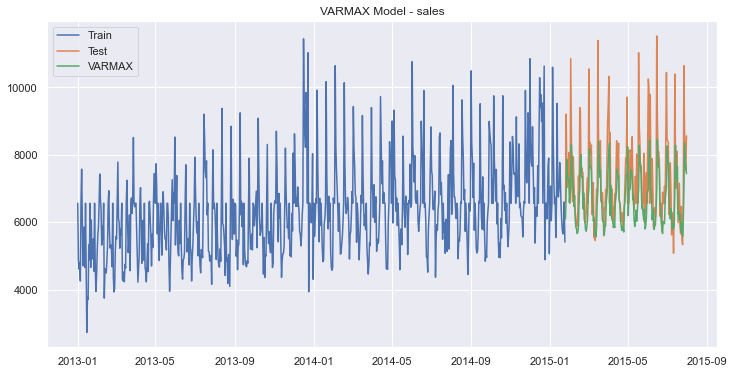

In [180]:
plt.figure(figsize=(12,6)) 
plt.plot(train['sales'], label='Train')
plt.plot(test['sales'], label='Test')
plt.plot(predictions['VARMAX_forecast_Sales'], label='VARMAX')
plt.legend(loc='best')
plt.title('VARMAX Model - sales')
plt.show()

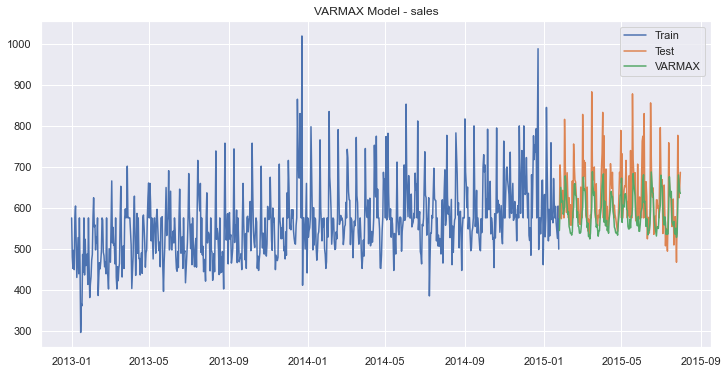

In [181]:
plt.figure(figsize=(12,6)) 
plt.plot(train['customers'], label='Train')
plt.plot(test['customers'], label='Test')
plt.plot(predictions['VARMAX_forecast_customers'], label='VARMAX')
plt.legend(loc='best')
plt.title('VARMAX Model - sales')
plt.show()

**Model Evaluation**

In [183]:
# Let's calculate the rmse and MAPE
rmse = np.sqrt(mean_squared_error(test['sales'], predictions['VARMAX_forecast_Sales'])).round(2)
mape = np.round(np.mean(np.abs(test['sales']-predictions['VARMAX_forecast_Sales'])/test['sales'])*100,2)
tempResults = pd.DataFrame({'Method':['VARMAX'], 'RMSE': [rmse],'MAPE': [mape] })

In [184]:
results = pd.concat([results  , tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,ARIMA,1290.57,10.53
0,VAR,1566.32,13.08
0,VARMAX,1204.34,9.97


**VARMAX is the best model**


-  Is the sales data non-stationary? If so, how do you find it and correct it?

-  Is the data cointegrated? Which variables are cointegrated and how do you find them?

-  What is the impact of the number of customers on sales?

-  What is the impact of promo and promo2 variables on sales? How do you measure it?

-  **Forecast sales for the next 6 weeks? Report the accuracy of the model using MAPE**

-   Find outliers at the 99th percentile and remove them.

-   Standardize the sales and number of customers variables before modelling.

-   Determine if the data is stationary

-   If stationary then apply Vector Autoregression Model.

-   If non-stationary then specify the model in differences

-   Make sales, promo2 and any other variables you think of as dependent variables.

-   check for cointegration using the Johansen test. 

-   **Predict sales for the next 6 weeks**

# Conclusion


-   The data is stationary
-   Sales and Customers are cointegrated to each others
-   Sales will get increase as the number of customer will get increase.
-   promo has positive impact on sales
-   promo2 doesn't have any impact on sales
